# Adaptive Learning


In [2]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.2 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from skopt import gp_minimize
from skopt.plots import plot_convergence

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from skopt import gp_minimize
from skopt.plots import plot_convergence

import os
import glob
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic, Matern, Product, ConstantKernel as C
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pandas.plotting import parallel_coordinates
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import f_oneway


In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Approve the authentication prompts as needed

Mounted at /content/drive


In [5]:
# Define the path again (since Colab was reset)
file_path = '/content/drive/MyDrive/Thesis_Updated/AI_Data/material_with_simulated_sparams_extended.csv'

# Load the dataset
material_df = pd.read_csv(file_path)

# Define the path again (since Colab was reset)
file_path = '/content/drive/MyDrive/Thesis_Updated/AI_Data/simulated_s11_s21_round2.csv'

# Load the dataset
round_one = pd.read_csv(file_path)

# Calculate sigma
epsilon_0 = 8.854187817e-12  # Vacuum permittivity
material_df['sigma'] = 2 * np.pi * material_df['frequency'] * material_df['epsilon_imag'] * epsilon_0
round_one['sigma'] = 2 * np.pi * round_one['frequency'] * round_one['epsilon_imag'] * epsilon_0

# Calculate Reflection (R), Transmission (T), Absorption (A)
material_df['R'] = np.abs(material_df['s11'])**2
material_df['T'] = np.abs(material_df['s21'])**2
material_df['A'] = 1 - material_df['R'] - material_df['T']

round_one['R'] = np.abs(round_one['corrected_s11'])**2
round_one['T'] = np.abs(round_one['corrected_s21'])**2
round_one['A'] = 1 - round_one['R'] - material_df['T']

# Split into ABS and PBT sets
abs_df = material_df[material_df['material'] == 'ABS'].copy()
pbt_df = material_df[material_df['material'] == 'PBT'].copy()

abs_r1 = round_one[round_one['material'] == 'ABS'].copy()
pbt_r1 = round_one[round_one['material'] == 'PBT'].copy()

# Display shapes to confirm data loaded and processed
abs_df.shape, pbt_df.shape,abs_r1.shape, pbt_r1.shape

((1500, 16), (2200, 16), (1500, 20), (1500, 20))

In [6]:
abs_r1

frequency  epsilon_real  epsilon_imag  mu_real  mu_imag  s11  s21  \
0     1.240000e+10      8.497572     13.703218      1.0      0.0  NaN  NaN   
1     1.245657e+10      8.485320     13.770313      1.0      0.0  NaN  NaN   
2     1.251313e+10      8.470742     13.835384      1.0      0.0  NaN  NaN   
3     1.256970e+10      8.453787     13.898315      1.0      0.0  NaN  NaN   
4     1.262626e+10      8.434407     13.958997      1.0      0.0  NaN  NaN   
...            ...           ...           ...      ...      ...  ...  ...   
1495  1.777374e+10      3.007556     12.630354      1.0      0.0  NaN  NaN   
1496  1.783030e+10      2.981597     12.542812      1.0      0.0  NaN  NaN   
1497  1.788687e+10      2.958497     12.455032      1.0      0.0  NaN  NaN   
1498  1.794343e+10      2.938221     12.367089      1.0      0.0  NaN  NaN   
1499  1.800000e+10      2.920718     12.279057      1.0      0.0  NaN  NaN   

      cnt_pct material  thickness                                     sim_s11  \
0         4.0      ABS        1.8    (0.5343574586224419+0.5954615933586886j)   
1         4.0      ABS        1.8   (0.7811757558363439-0.17031901025815074j)   
2         4.0      ABS        1.8   (0.23709750041279962-0.7613353935056143j)   
3         4.0      ABS        1.8   (-0.5411830371220783-0.5816154890312386j)   
4         4.0      ABS        1.8  (-0.7729460650872911+0.17362014023367753j)   
...       ...      ...        ...                                         ...   
1495      2.0      ABS        1.7  (-0.6459208897664098-0.31420254014829085j)   
1496      2.0      ABS        1.7  (-0.6717994324266338+0.25584760681981267j)   
1497      2.0      ABS        1.7    (-0.2796606051410256+0.663379762013839j)   
1498      2.0      ABS        1.7    (0.2813541048681328+0.6634982383195428j)   
1499      2.0      ABS        1.7   (0.6710167591351763+0.26210828153332116j)   

                                               sim_s21  sim_s11_mag  \
0     (-0.00038546111279121227+0.0003331980469541546j)     0.800070   
1      (0.00011399962467099568+0.0004952055859047606j)     0.799527   
2      (0.0004882080006933512+0.00013217047117666756j)     0.797400   
3     (0.00034633828982112605-0.00036302919499129244j)     0.794453   
4      (-0.0001479435060468046-0.0004743858482254849j)     0.792206   
...                                                ...          ...   
1495  (-9.984769120574799e-05+0.00013002452562832894j)     0.718288   
1496   (3.0116484581755308e-05+0.0001593097916080736j)     0.718869   
1497   (0.00013644442863012323+8.308025228052508e-05j)     0.719919   
1498   (0.00015121290128901512-4.403021322332456e-05j)     0.720687   
1499    (6.951644207718897e-05-0.0001397663221859756j)     0.720392   

      sim_s21_mag  corrected_s11  corrected_s21      sigma         R  \
0        0.000510       0.918371       0.010604   9.453070  0.843406   
1        0.000508       0.917828       0.010602   9.542688  0.842409   
2        0.000506       0.915701       0.010600   9.631320  0.838508   
3        0.000502       0.912754       0.010596   9.718865  0.833120   
4        0.000497       0.910506       0.010591   9.805227  0.829022   
...           ...            ...            ...        ...       ...   
1495     0.000164       0.691738       0.249627  12.488862  0.478502   
1496     0.000162       0.692320       0.249626  12.441772  0.479306   
1497     0.000160       0.693369       0.249623  12.393894  0.480761   
1498     0.000157       0.694138       0.249621  12.345300  0.481827   
1499     0.000156       0.693842       0.249620  12.296064  0.481417   

             T         A  
0     0.000112  0.154542  
1     0.000112  0.155539  
2     0.000112  0.159440  
3     0.000112  0.164828  
4     0.000112  0.168926  
...        ...       ...  
1495  0.062314  0.516363  
1496  0.062313  0.515629  
1497  0.062312  0.514200  
1498  0.062311  0.513121  
1499  0.062310  0.513620  

[1500 rows x 20 columns]

In [22]:
pbt_r1

frequency  epsilon_real  epsilon_imag  mu_real  mu_imag  s11  s21  \
1500  1.240000e+10      7.464212      3.074078      1.0      0.0  NaN  NaN   
1501  1.245657e+10      7.425481      3.023044      1.0      0.0  NaN  NaN   
1502  1.251313e+10      7.385761      2.971947      1.0      0.0  NaN  NaN   
1503  1.256970e+10      7.345040      2.920804      1.0      0.0  NaN  NaN   
1504  1.262626e+10      7.303361      2.869654      1.0      0.0  NaN  NaN   
...            ...           ...           ...      ...      ...  ...  ...   
2995  1.777374e+10      5.122857      1.500533      1.0      0.0  NaN  NaN   
2996  1.783030e+10      5.198271      1.588882      1.0      0.0  NaN  NaN   
2997  1.788687e+10      5.277979      1.681247      1.0      0.0  NaN  NaN   
2998  1.794343e+10      5.361659      1.777290      1.0      0.0  NaN  NaN   
2999  1.800000e+10      5.448916      1.876616      1.0      0.0  NaN  NaN   

      cnt_pct material  thickness  \
1500      5.5      PBT        1.1   
1501      5.5      PBT        1.1   
1502      5.5      PBT        1.1   
1503      5.5      PBT        1.1   
1504      5.5      PBT        1.1   
...       ...      ...        ...   
2995      5.5      PBT        1.6   
2996      5.5      PBT        1.6   
2997      5.5      PBT        1.6   
2998      5.5      PBT        1.6   
2999      5.5      PBT        1.6   

                                          sim_s11  \
1500   (0.39589899655161076+0.40681368963315295j)   
1501      (0.542260286831334-0.1419221158678493j)   
1502    (0.14176202332263715-0.5337110851019653j)   
1503   (-0.3878928481320918-0.38201102365369727j)   
1504   (-0.5194158595829601+0.14131693065875142j)   
...                                           ...   
2995   (-0.46258292127745043-0.2703212403933603j)   
2996   (-0.5116440096622962+0.15576025336999433j)   
2997  (-0.23658187069259695+0.47959806938326743j)   
2998    (0.18310657259309898+0.5003201220434359j)   
2999    (0.4824465435252253+0.21289536391510072j)   

                                          sim_s21  sim_s11_mag  sim_s21_mag  \
1500   (0.12359498483307592-0.30552907550574354j)     0.567656     0.329581   
1501     (-0.214817368136961-0.2539853360109567j)     0.560525     0.332649   
1502   (-0.32757310193536215+0.0709290031390951j)     0.552217     0.335164   
1503   (-0.09377318652210542+0.3234688374509483j)     0.544420     0.336787   
1504   (0.23889673334146005+0.23909930095454232j)     0.538297     0.337994   
...                                           ...          ...          ...   
2995     (0.1437822432654326-0.3815585400082272j)     0.535777     0.407750   
2996  (-0.18693434961816863-0.36214175495250145j)     0.534828     0.407543   
2997   (-0.3940187091871149-0.10532234533643846j)     0.534776     0.407852   
2998  (-0.34460186109065305+0.22095488270989913j)     0.532774     0.409355   
2999  (-0.06908068497866199+0.40604746887715826j)     0.527332     0.411882   

      corrected_s11  corrected_s21     sigma         R         T         A  
1500       0.769156       0.438498  2.120631  0.591601  0.192281  0.382162  
1501       0.762025       0.441566  2.094939  0.580682  0.194980  0.392983  
1502       0.753717       0.444081  2.068882  0.568090  0.197208  0.405232  
1503       0.745920       0.445704  2.042471  0.556397  0.198652  0.416858  
1504       0.739797       0.446911  2.015733  0.547299  0.199730  0.425953  
...             ...            ...       ...       ...       ...       ...  
2995       0.742044       0.447186  1.483723  0.550629  0.199976  0.313947  
2996       0.741095       0.446979  1.576083  0.549222  0.199790  0.315354  
2997       0.741043       0.447288  1.672994  0.549145  0.200067  0.315431  
2998       0.739041       0.448791  1.774158  0.546182  0.201413  0.317657  
2999       0.733599       0.451318  1.879215  0.538168  0.203688  0.326408  

[1500 rows x 20 columns]

In [23]:
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]

# Define training columns
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]
selected_columns = input_features + output_targets

# Combine ABS data
abs_combined = pd.concat([abs_df[selected_columns], abs_r1[selected_columns]], ignore_index=True)

# Combine PBT data
pbt_combined = pd.concat([pbt_df[selected_columns], pbt_r1[selected_columns]], ignore_index=True)

abs_combined.shape, pbt_combined.shape


((3000, 8), (3700, 8))

Regularizer

In [7]:
!pip install gpytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Load Old Models

In [20]:
import os
import joblib
import torch
import gpytorch
from sklearn.preprocessing import StandardScaler

# === Your Latest Multi-Output GPyTorch Class ===
class ExactMultiOutputGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            ), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)

# === Paths ===
base_path = '/content/drive/MyDrive/Thesis_Updated/Models/Pipeline2'
vanilla_path = os.path.join(base_path, 'Vanilla')
round2_path = os.path.join(base_path, 'Round2')
round3_path = os.path.join(base_path, 'Round3')

# === Load Sklearn Vanilla Models ===
abs_gpr_vanilla = joblib.load(os.path.join(vanilla_path, 'ABS_GPR_Sklearn_20250403_172200.pkl'))
pbt_gpr_vanilla = joblib.load(os.path.join(vanilla_path, 'PBT_GPR_Sklearn_20250403_172200.pkl'))
print("✅ Vanilla Models Loaded")

# === Loader for GPyTorch Models ===
def load_gpytorch_model(model_path, likelihood_path, scaler_path):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
    dummy_x = torch.zeros(1, 5)  # 5 input features
    dummy_y = torch.zeros(1, 3)  # 3 output targets
    model = ExactMultiOutputGPModel(dummy_x, dummy_y, likelihood)

    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    likelihood.load_state_dict(torch.load(likelihood_path, map_location='cpu'))
    scaler = joblib.load(scaler_path)

    model.eval()
    likelihood.eval()

    return model, likelihood, scaler

# === Load Round 2 ===
abs_model_r2, abs_likelihood_r2, abs_scaler_r2 = load_gpytorch_model(
    os.path.join(round2_path, 'ABS_gp_model.pth'),
    os.path.join(round2_path, 'ABS_likelihood.pth'),
    os.path.join(round2_path, 'ABS_scaler.pkl')
)

pbt_model_r2, pbt_likelihood_r2, pbt_scaler_r2 = load_gpytorch_model(
    os.path.join(round2_path, 'PBT_gp_model.pth'),
    os.path.join(round2_path, 'PBT_likelihood.pth'),
    os.path.join(round2_path, 'PBT_scaler.pkl')
)

print("✅ Round 2 Models Loaded")

# === Load Round 3 ===
abs_model_r3, abs_likelihood_r3, abs_scaler_r3 = load_gpytorch_model(
    os.path.join(round3_path, 'ABS_gp_model.pth'),
    os.path.join(round3_path, 'ABS_likelihood.pth'),
    os.path.join(round3_path, 'ABS_scaler.pkl')
)

pbt_model_r3, pbt_likelihood_r3, pbt_scaler_r3 = load_gpytorch_model(
    os.path.join(round3_path, 'PBT_gp_model.pth'),
    os.path.join(round3_path, 'PBT_likelihood.pth'),
    os.path.join(round3_path, 'PBT_scaler.pkl')
)

print("✅ Round 3 Models Loaded")


✅ Vanilla Models Loaded
✅ Round 2 Models Loaded
✅ Round 3 Models Loaded


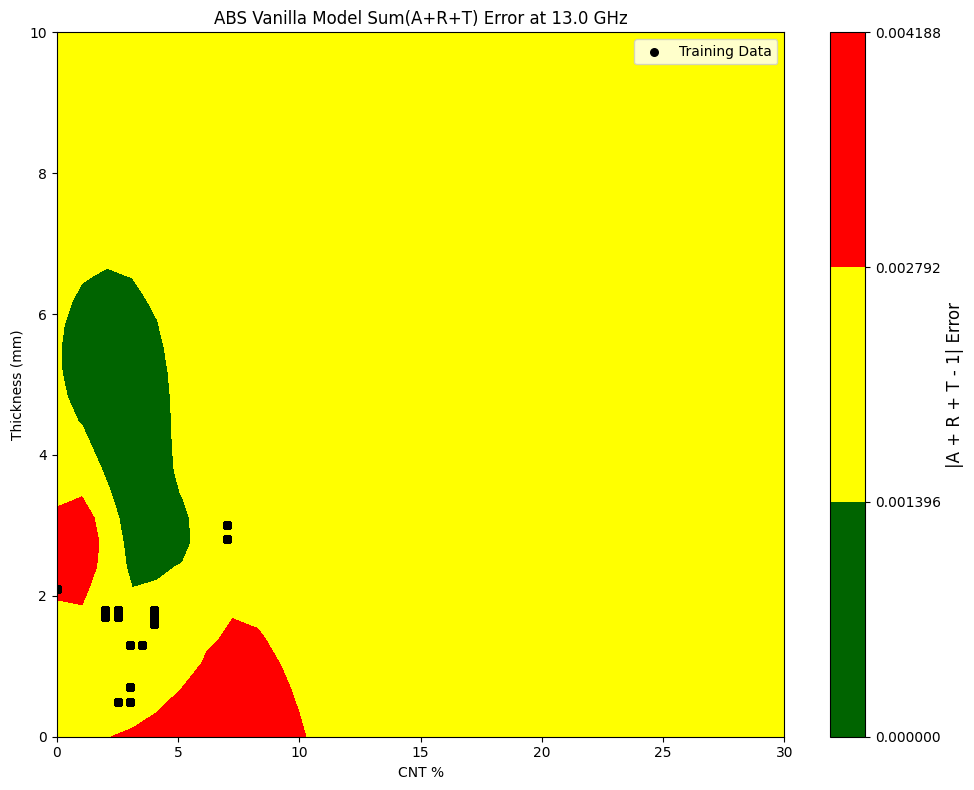

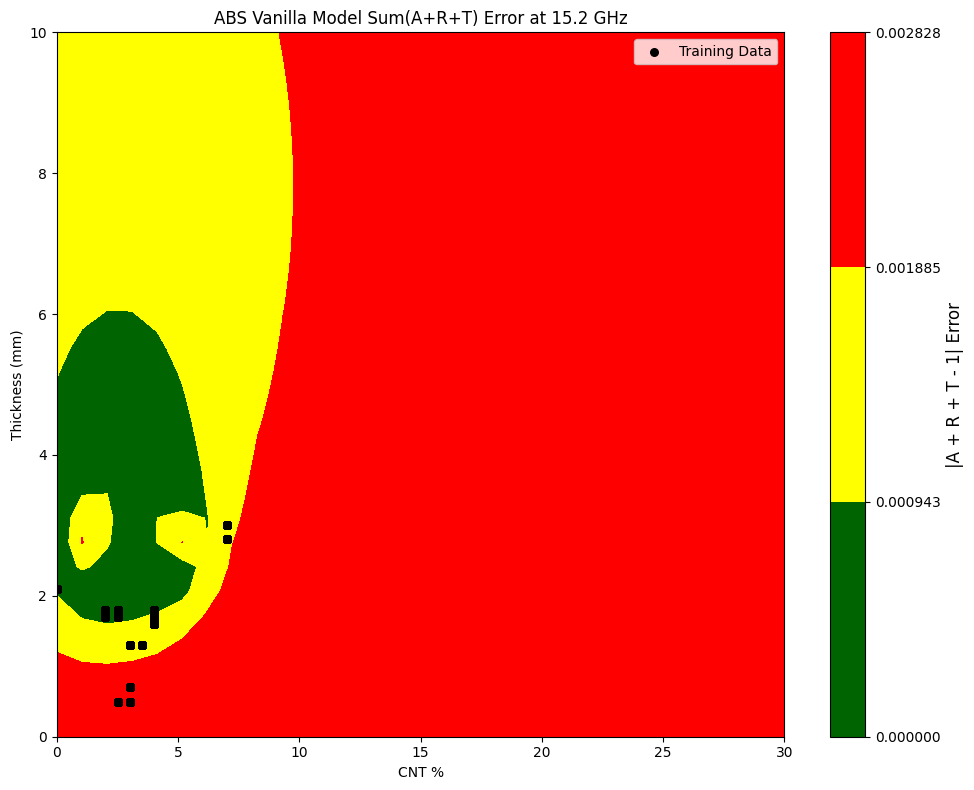

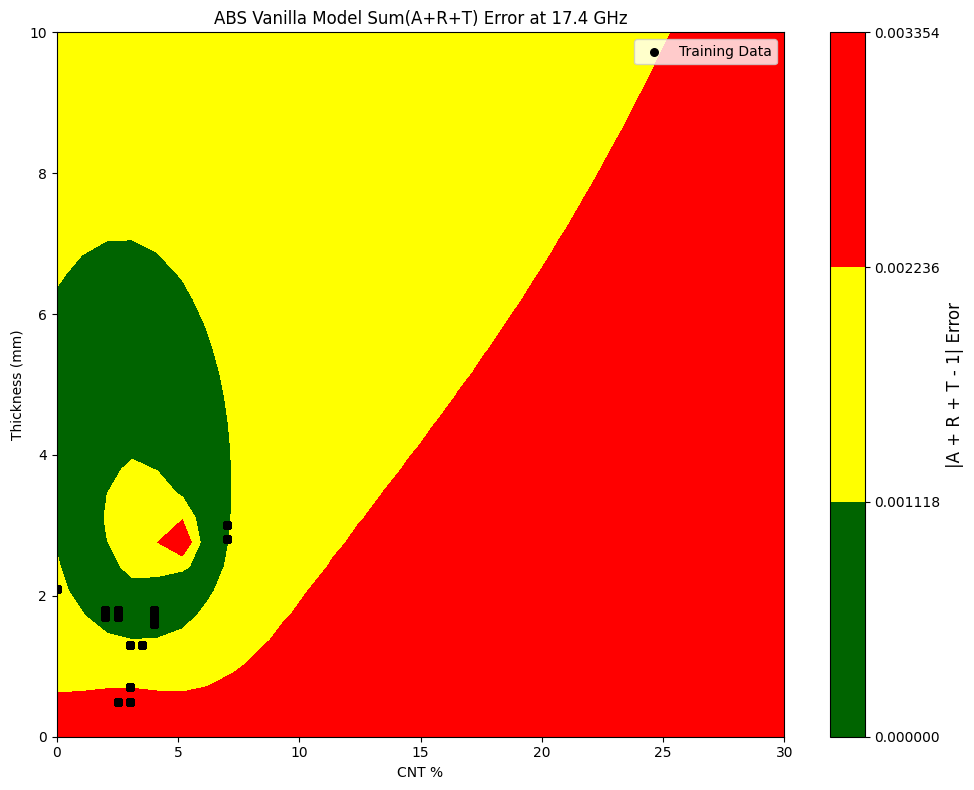

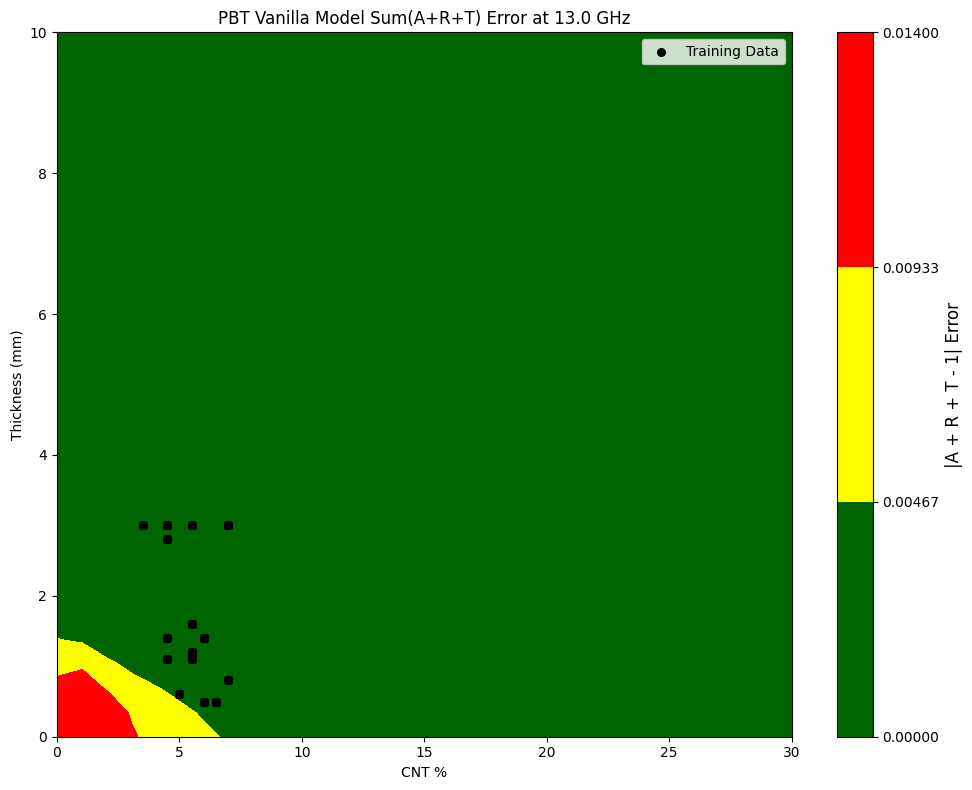

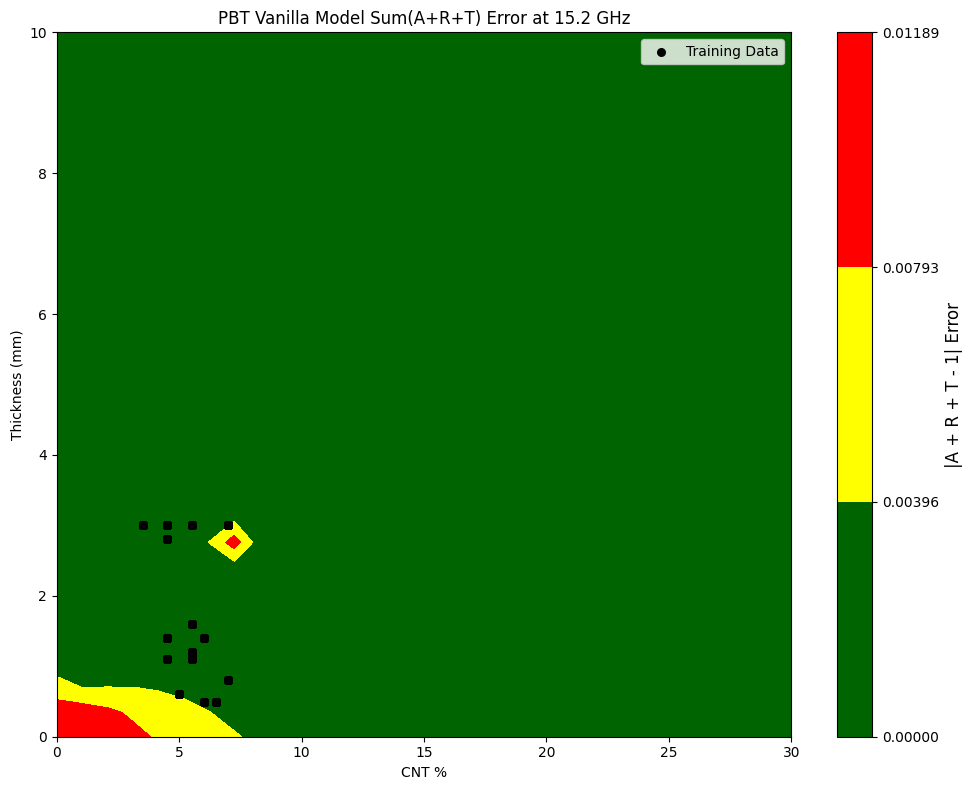

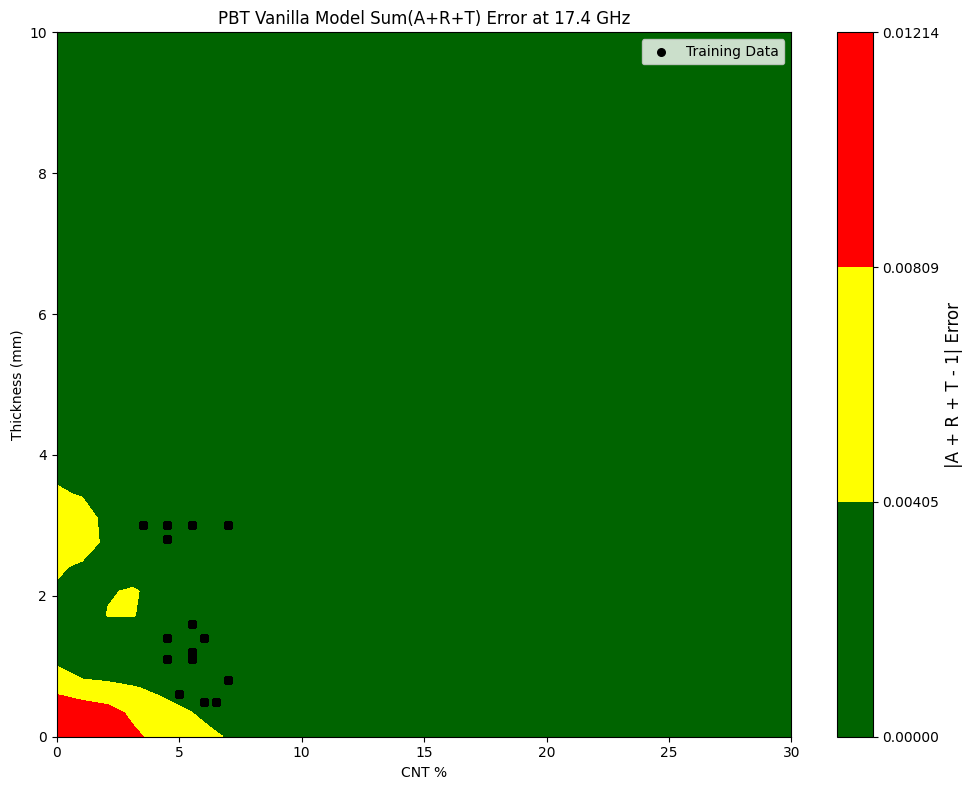

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_sum_constraint_vanilla(model_dict, df_data, material_name="ABS",
                                cnt_bounds=(0, 30), thick_bounds=(0, 10),
                                resolution=30, freqs=[13e9, 15.2e9, 17.4e9]):

    cnt_min, cnt_max = cnt_bounds
    thick_min, thick_max = thick_bounds

    CNT_grid = np.linspace(cnt_min, cnt_max, resolution)
    Thickness_grid = np.linspace(thick_min, thick_max, resolution)
    CNT_grid, Thickness_grid = np.meshgrid(CNT_grid, Thickness_grid)

    for f in freqs:
        X_pred = np.c_[
            CNT_grid.ravel(),
            Thickness_grid.ravel(),
            np.full(CNT_grid.size, f),
            np.full(CNT_grid.size, 2.0),  # eps_real placeholder
            np.full(CNT_grid.size, 0.01)  # sigma placeholder
        ]

        y_pred = model_dict['model'].predict(X_pred)
        sum_pred = np.sum(y_pred, axis=1)
        error = np.abs(sum_pred - 1).reshape(CNT_grid.shape)

        # --- Auto-select Levels ---
        if error.max() < 0.05:
            levels = [0, error.max()/3, 2*error.max()/3, error.max()]
        else:
            levels = [0, 0.01, 0.05, error.max()]

        colors = ['darkgreen', 'yellow', 'red']

        plt.figure(figsize=(10, 8))
        contour = plt.contourf(CNT_grid, Thickness_grid, error, levels=levels, colors=colors)
        cbar = plt.colorbar(contour)
        cbar.set_label('|A + R + T - 1| Error', fontsize=12)

        df_subset = df_data[df_data["material"] == material_name]
        plt.scatter(df_subset["cnt_pct"], df_subset["thickness"], c='black', s=30, label='Training Data')

        plt.xlabel('CNT %')
        plt.ylabel('Thickness (mm)')
        plt.title(f'{material_name} Vanilla Model Sum(A+R+T) Error at {f/1e9:.1f} GHz')
        plt.legend()
        plt.tight_layout()
        plt.show()
plot_sum_constraint_vanilla(abs_gpr_vanilla, abs_r1, material_name="ABS")
plot_sum_constraint_vanilla(pbt_gpr_vanilla, pbt_r1, material_name="PBT")


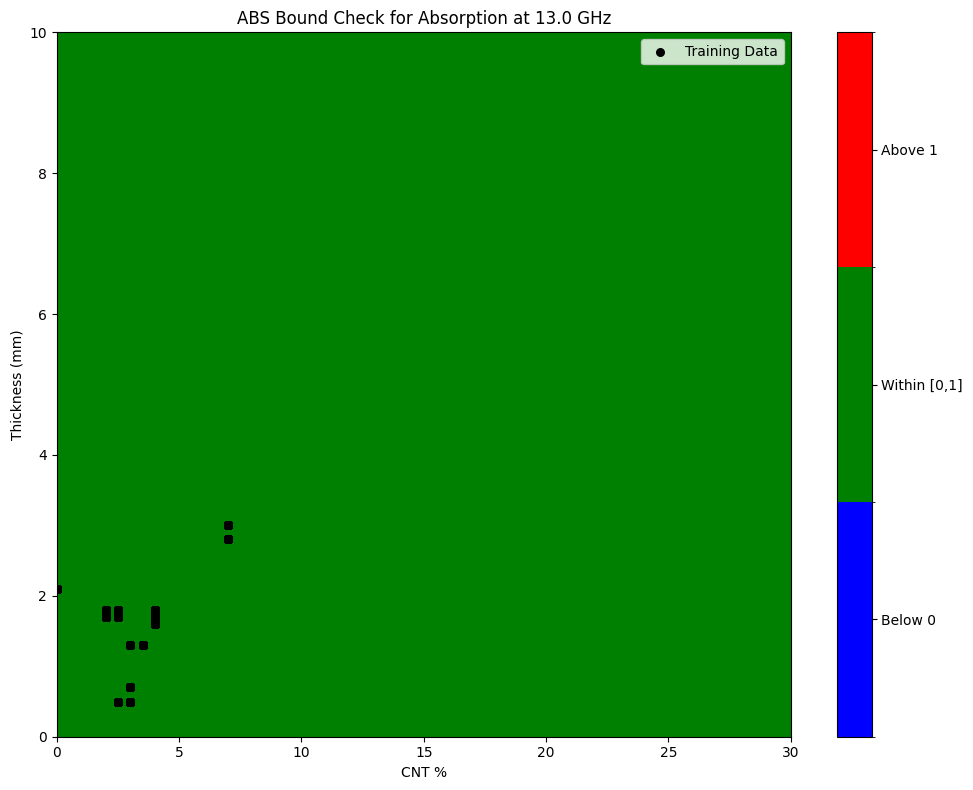

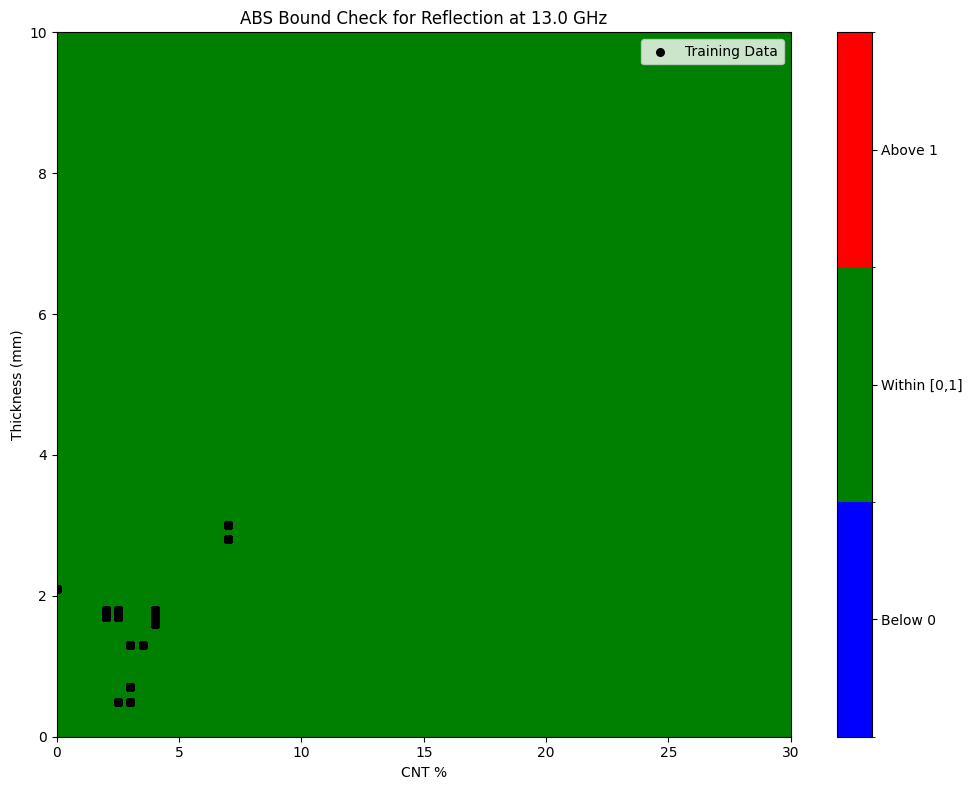

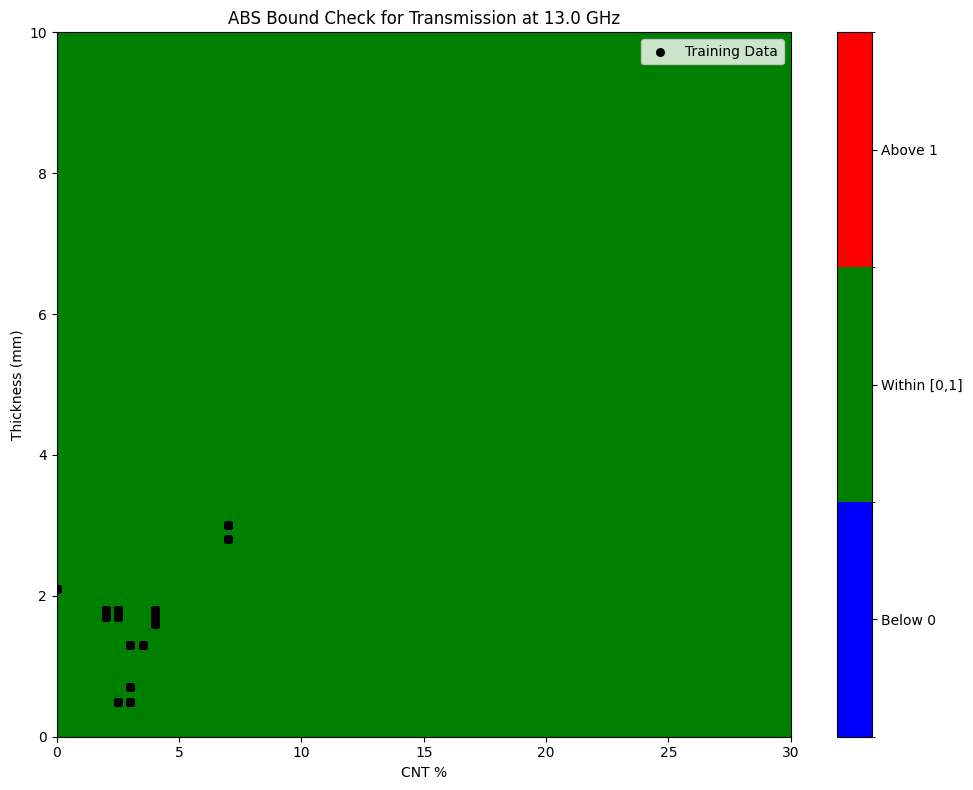

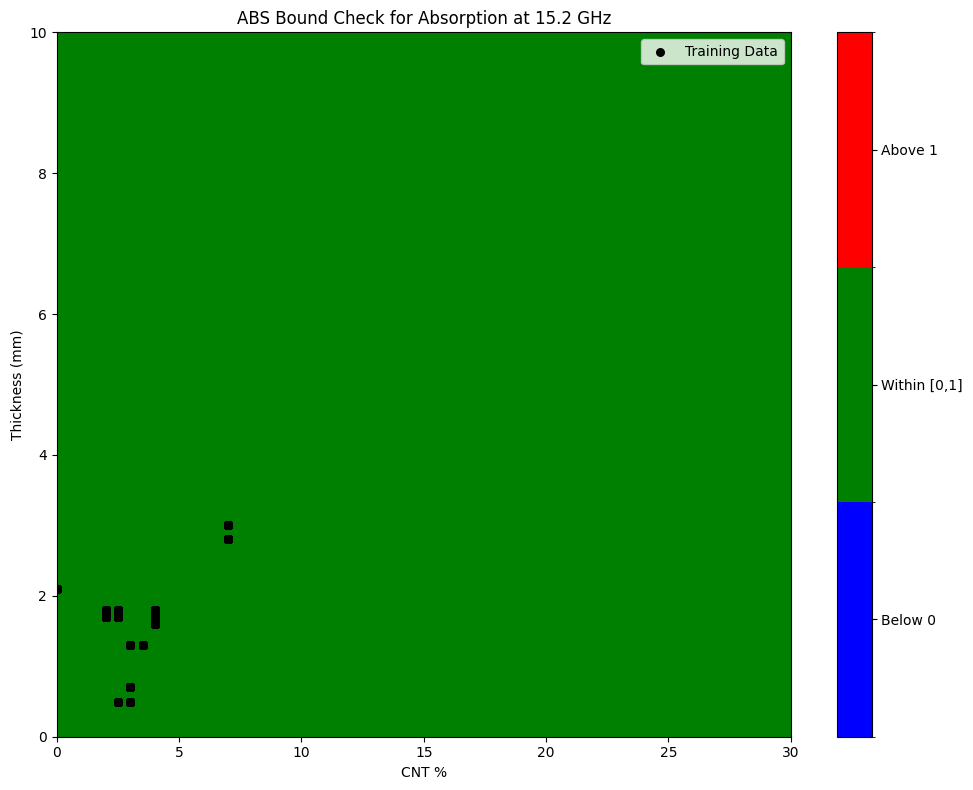

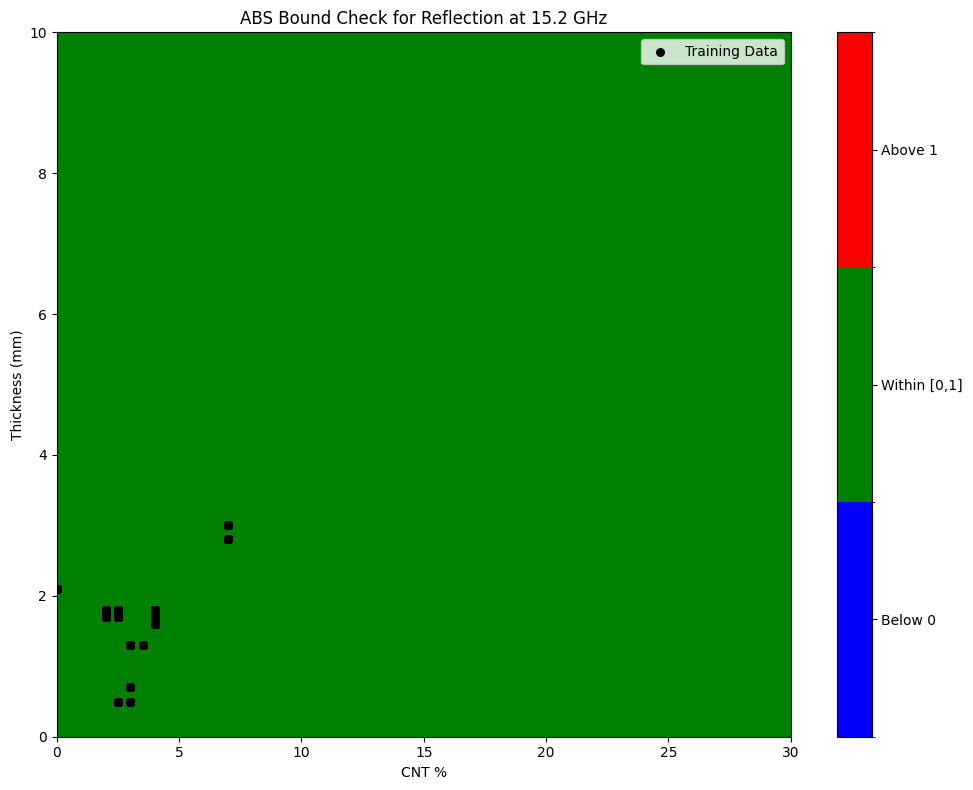

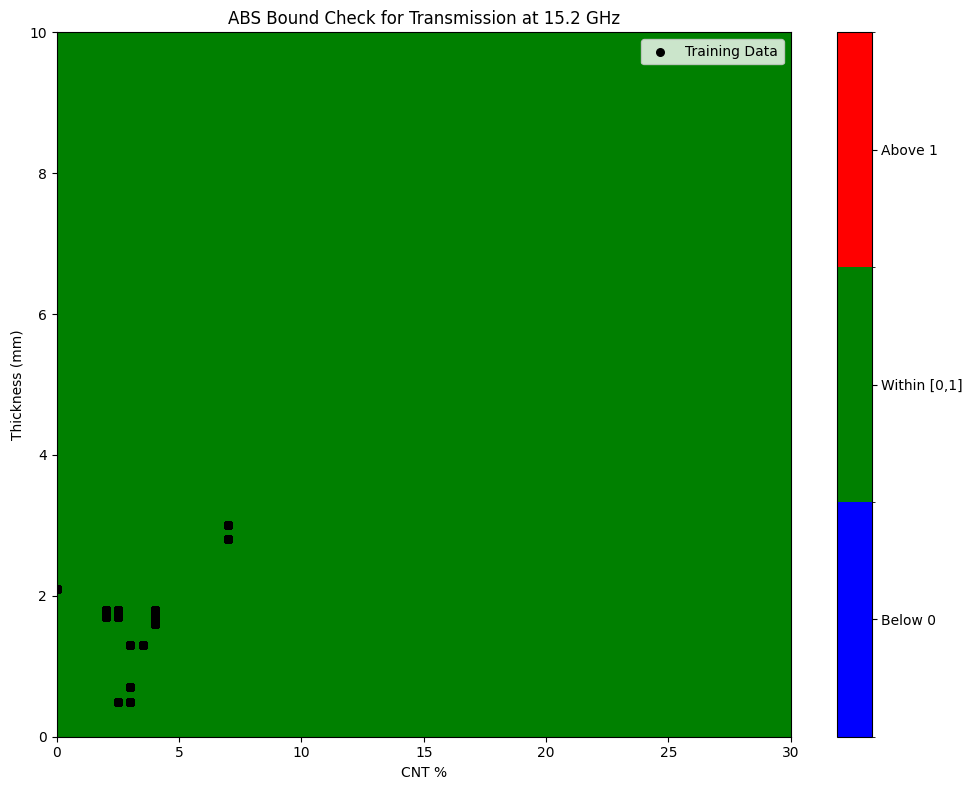

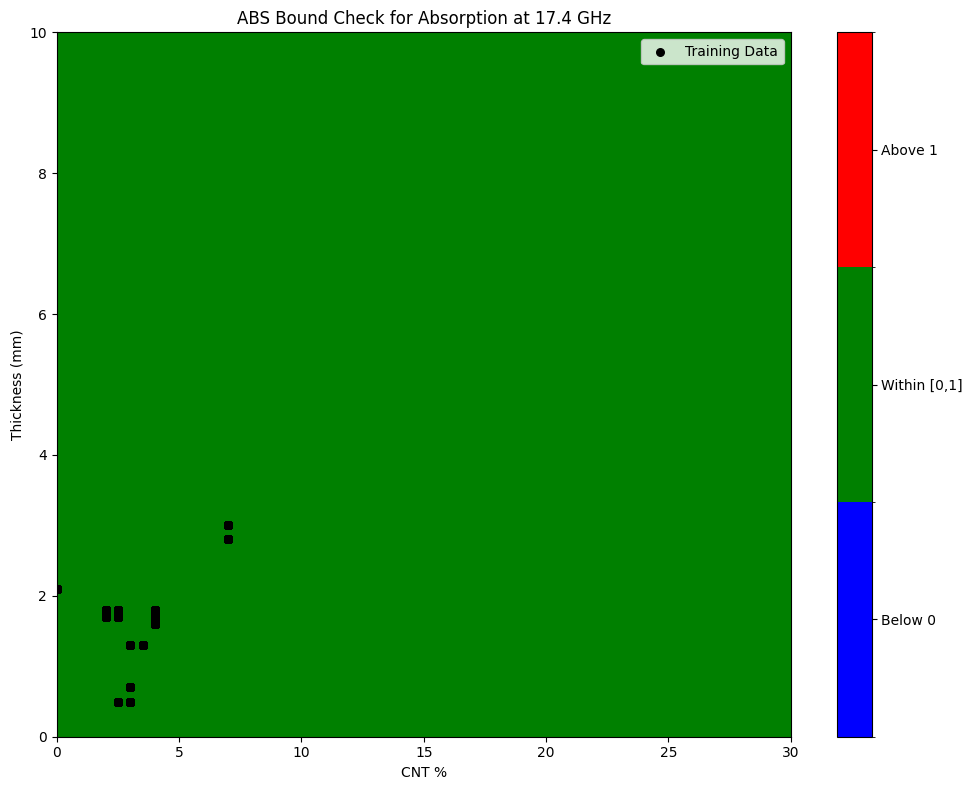

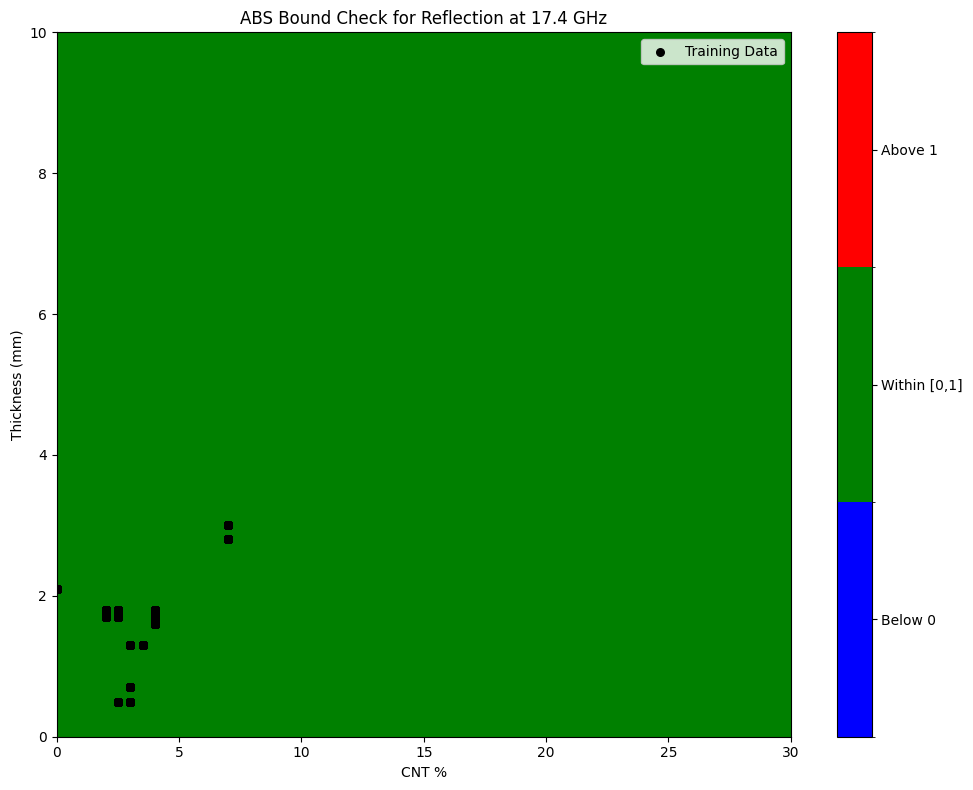

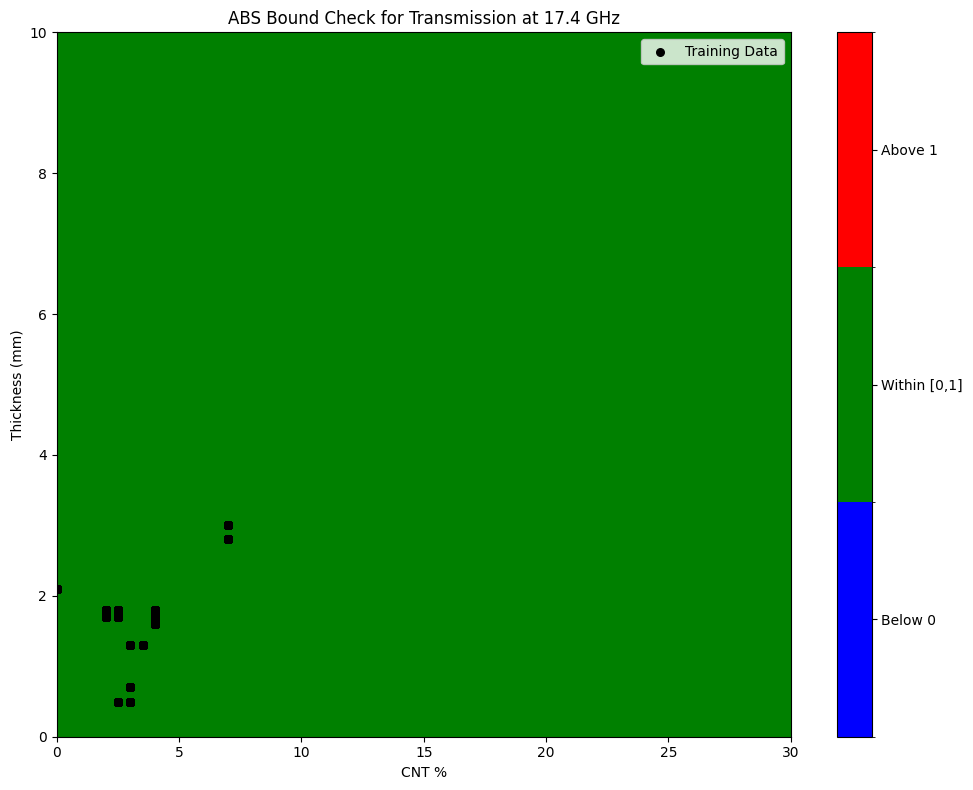

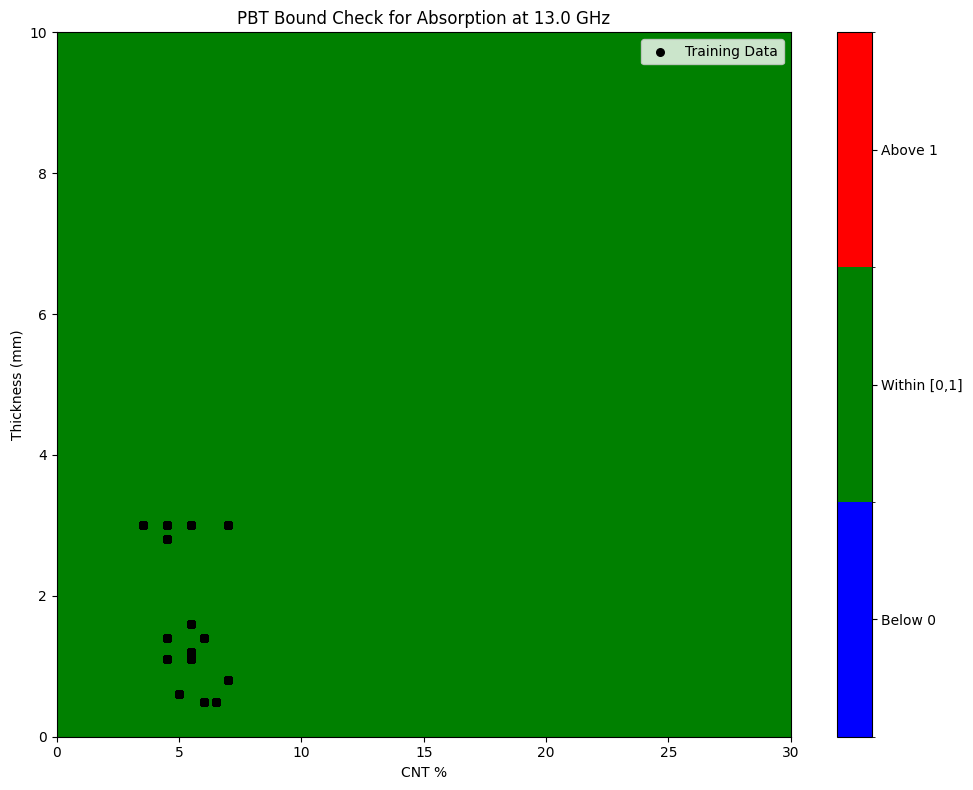

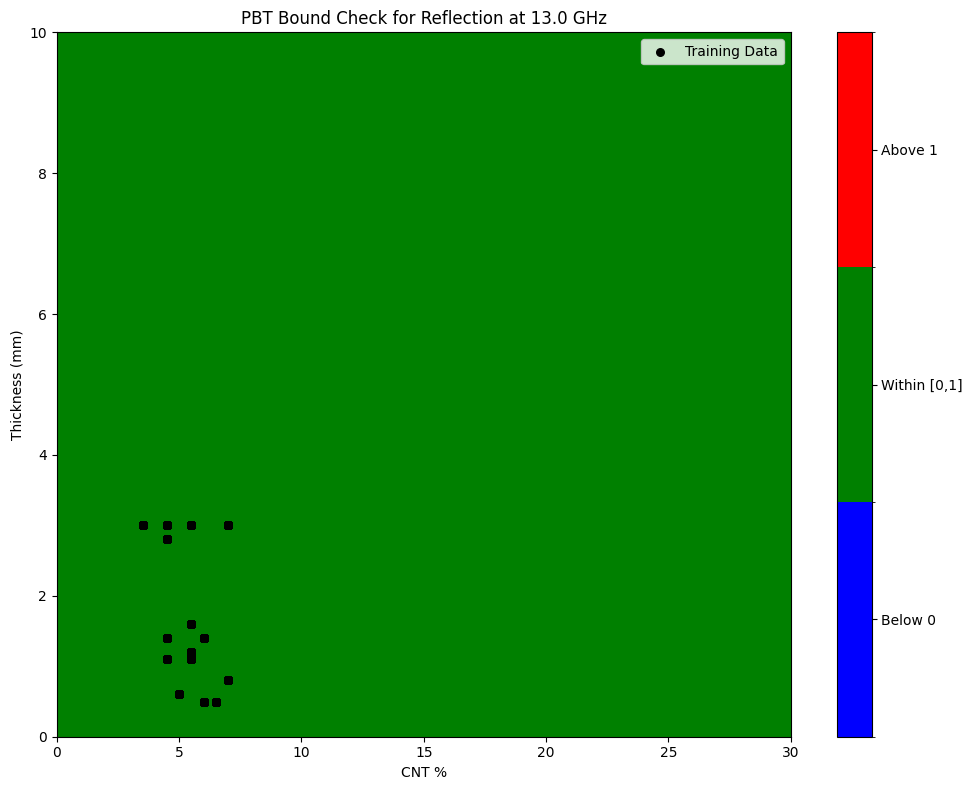

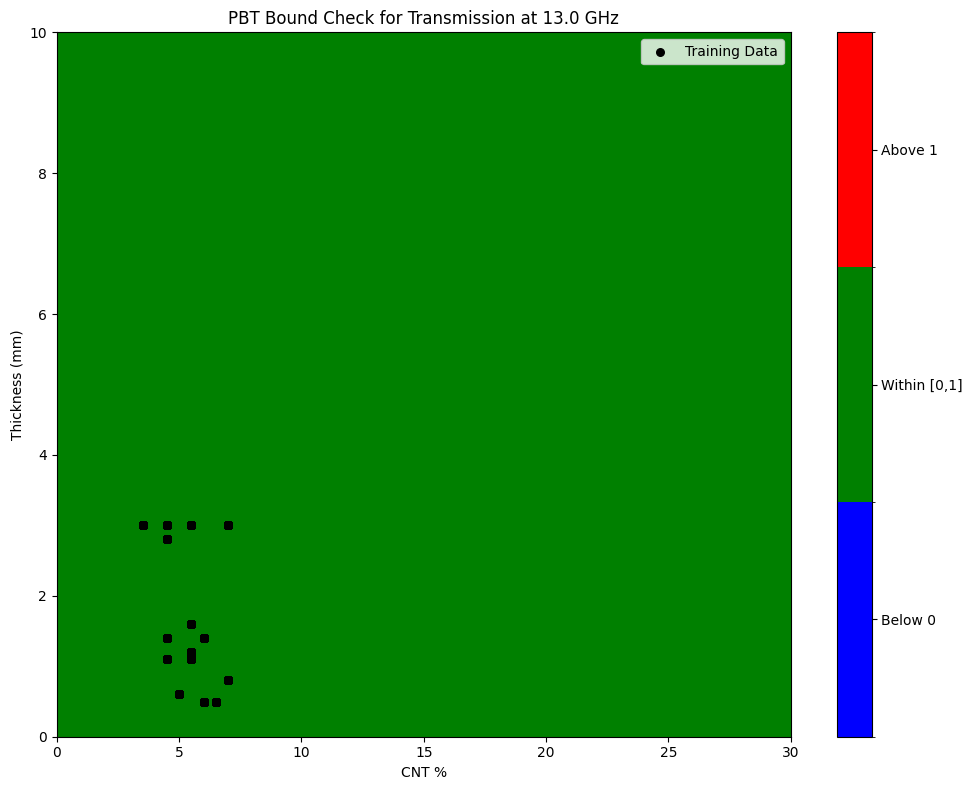

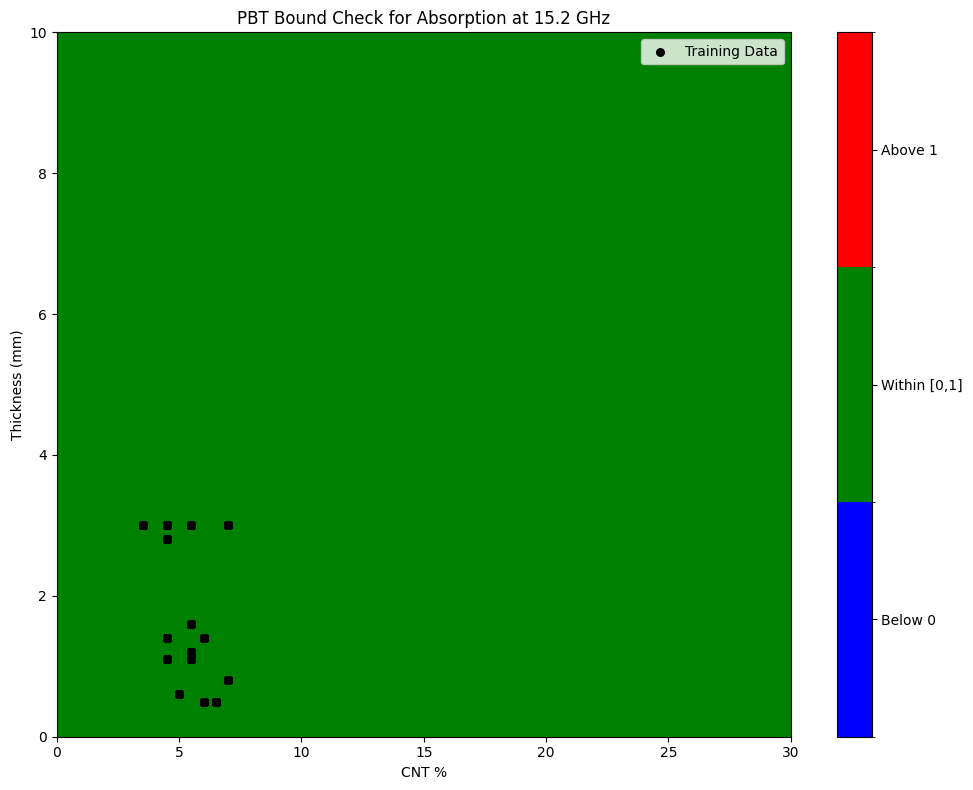

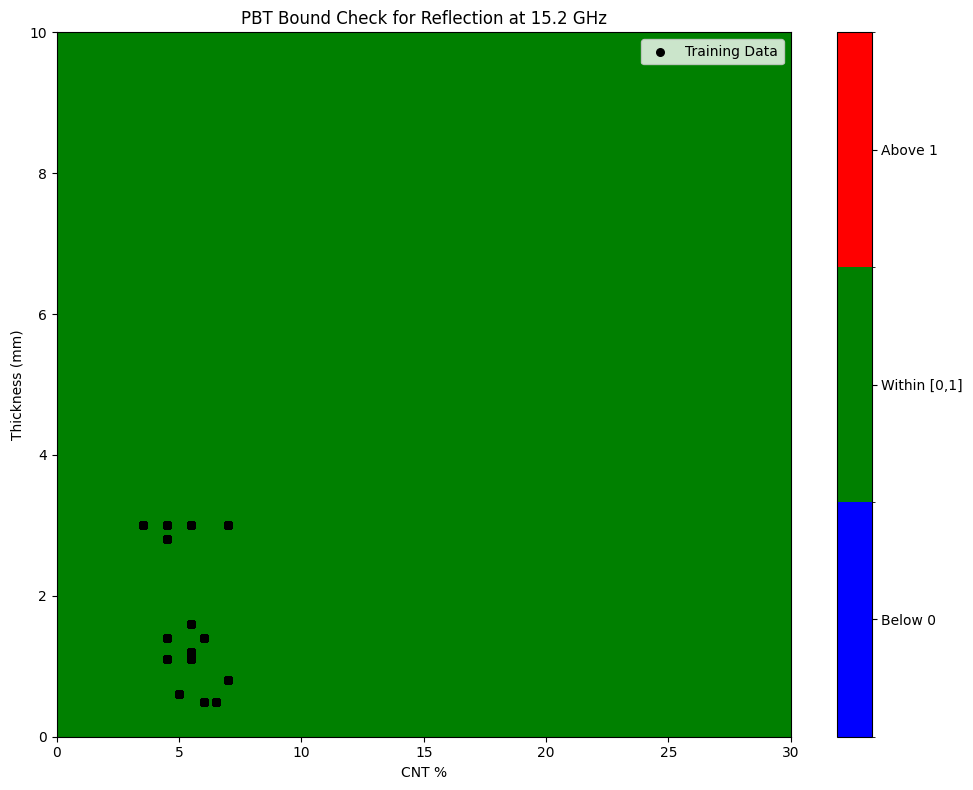

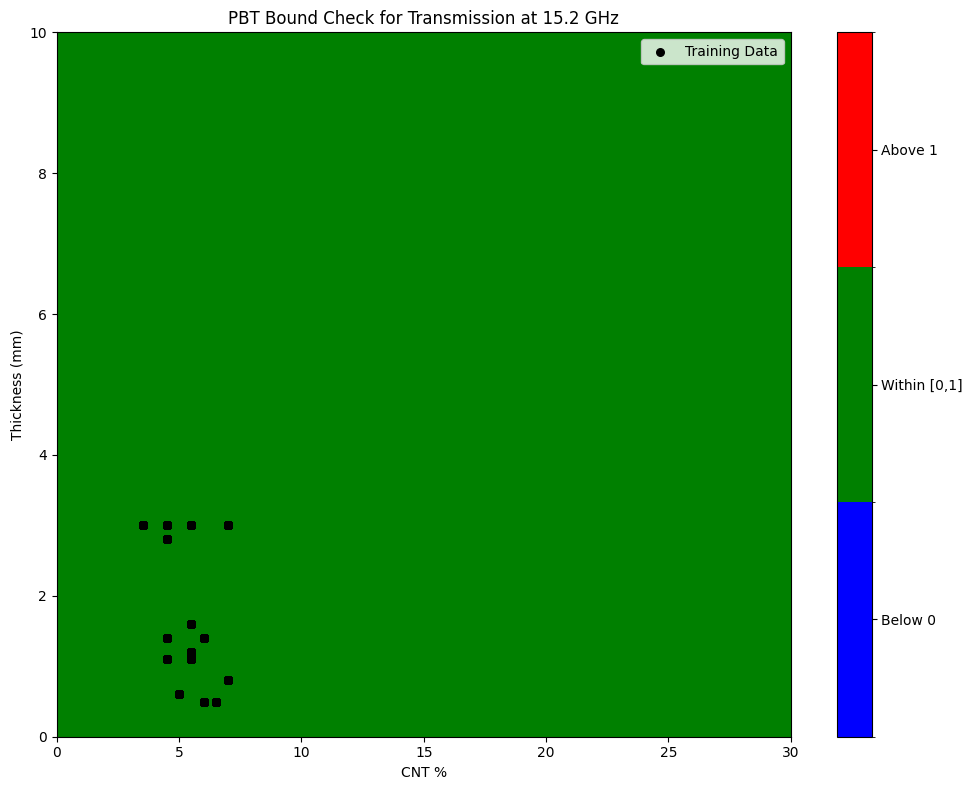

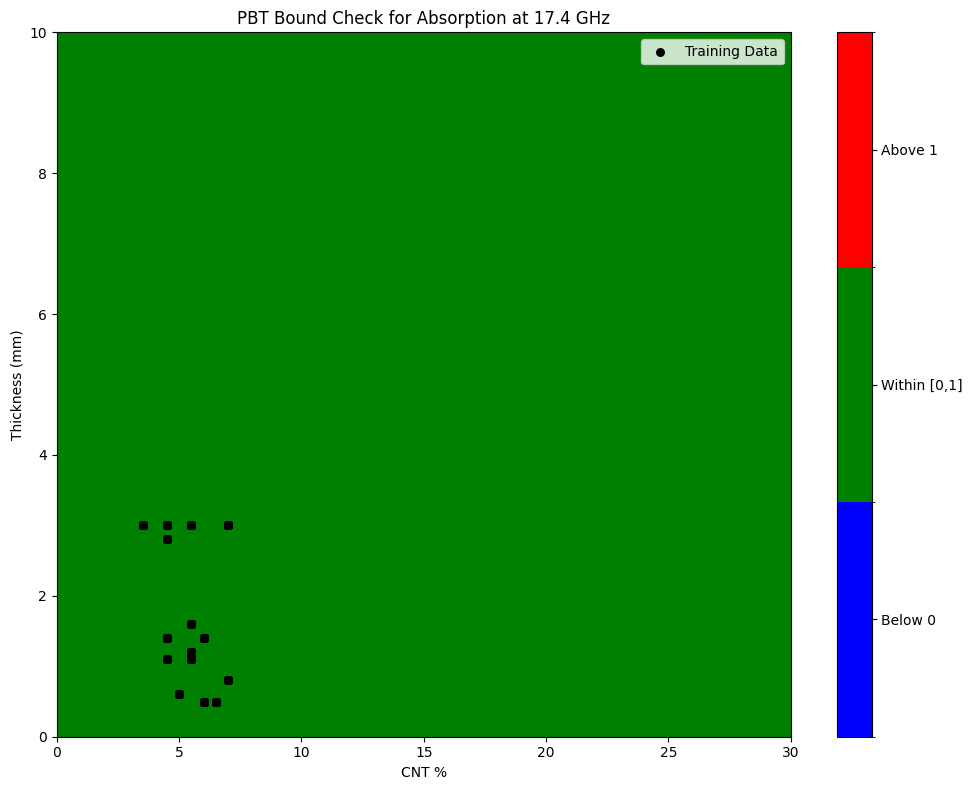

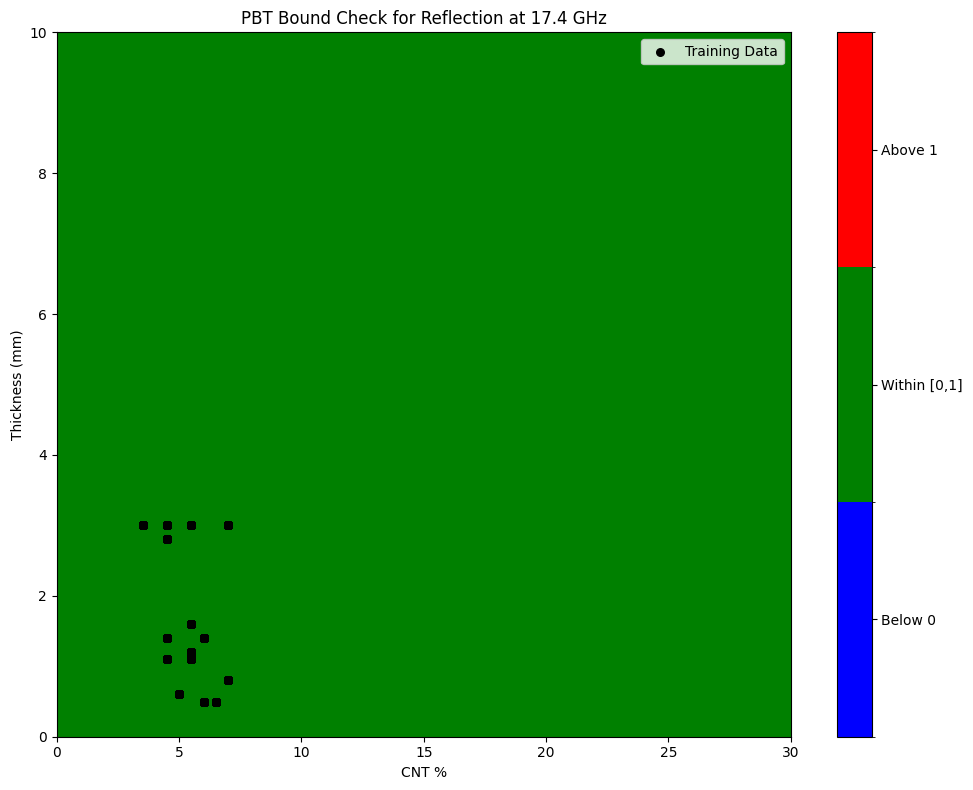

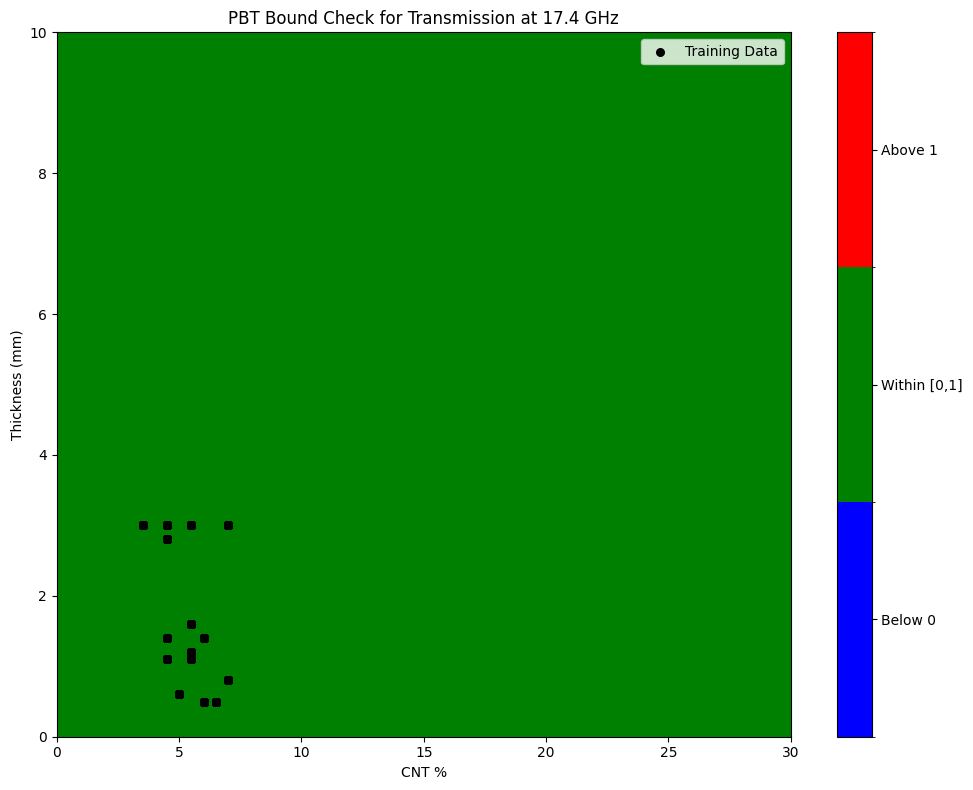

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_physical_bounds_vanilla(model_dict, df_data, material_name="ABS",
                                 cnt_bounds=(0, 30), thick_bounds=(0, 10),
                                 resolution=30, freqs=[13e9, 15.2e9, 17.4e9]):

    cnt_min, cnt_max = cnt_bounds
    thick_min, thick_max = thick_bounds

    CNT_grid = np.linspace(cnt_min, cnt_max, resolution)
    Thickness_grid = np.linspace(thick_min, thick_max, resolution)
    CNT_grid, Thickness_grid = np.meshgrid(CNT_grid, Thickness_grid)

    for f in freqs:
        X_pred = np.c_[
            CNT_grid.ravel(),
            Thickness_grid.ravel(),
            np.full(CNT_grid.size, f),
            np.full(CNT_grid.size, 2.0),  # eps_real placeholder
            np.full(CNT_grid.size, 0.01)  # sigma placeholder
        ]

        y_pred = model_dict['model'].predict(X_pred)
        y_pred = y_pred.reshape(-1, 3)  # (N, 3)

        for idx, target in enumerate(['Absorption', 'Reflection', 'Transmission']):
            z = y_pred[:, idx].reshape(CNT_grid.shape)

            # 0 = Below 0, 1 = In [0,1], 2 = Above 1
            condition_map = np.zeros_like(z)
            condition_map[(z >= 0) & (z <= 1)] = 1
            condition_map[z > 1] = 2

            cmap = ListedColormap(['blue', 'green', 'red'])
            bounds = [-0.5, 0.5, 1.5, 2.5]
            norm = BoundaryNorm(bounds, cmap.N)

            plt.figure(figsize=(10, 8))
            plt.title(f'{material_name} Bound Check for {target} at {f/1e9:.1f} GHz')
            plt.xlabel('CNT %')
            plt.ylabel('Thickness (mm)')
            plt.scatter(df_data["cnt_pct"], df_data["thickness"], c='black', s=30, label='Training Data')

            img = plt.imshow(condition_map, extent=(cnt_min, cnt_max, thick_min, thick_max),
                             origin='lower', cmap=cmap, norm=norm, aspect='auto')

            cbar = plt.colorbar(img, ticks=[0, 1, 2])
            cbar.ax.set_yticklabels(['Below 0', 'Within [0,1]', 'Above 1'])
            plt.legend()
            plt.tight_layout()
            plt.show()
# For ABS Vanilla
plot_physical_bounds_vanilla(abs_gpr_vanilla, abs_r1, material_name="ABS")

# For PBT Vanilla
plot_physical_bounds_vanilla(pbt_gpr_vanilla, pbt_r1, material_name="PBT")


In [40]:
abs_r1

frequency  epsilon_real  epsilon_imag  mu_real  mu_imag  s11  s21  \
0     1.240000e+10      8.497572     13.703218      1.0      0.0  NaN  NaN   
1     1.245657e+10      8.485320     13.770313      1.0      0.0  NaN  NaN   
2     1.251313e+10      8.470742     13.835384      1.0      0.0  NaN  NaN   
3     1.256970e+10      8.453787     13.898315      1.0      0.0  NaN  NaN   
4     1.262626e+10      8.434407     13.958997      1.0      0.0  NaN  NaN   
...            ...           ...           ...      ...      ...  ...  ...   
1495  1.777374e+10      3.007556     12.630354      1.0      0.0  NaN  NaN   
1496  1.783030e+10      2.981597     12.542812      1.0      0.0  NaN  NaN   
1497  1.788687e+10      2.958497     12.455032      1.0      0.0  NaN  NaN   
1498  1.794343e+10      2.938221     12.367089      1.0      0.0  NaN  NaN   
1499  1.800000e+10      2.920718     12.279057      1.0      0.0  NaN  NaN   

      cnt_pct material  thickness                                     sim_s11  \
0         4.0      ABS        1.8    (0.5343574586224419+0.5954615933586886j)   
1         4.0      ABS        1.8   (0.7811757558363439-0.17031901025815074j)   
2         4.0      ABS        1.8   (0.23709750041279962-0.7613353935056143j)   
3         4.0      ABS        1.8   (-0.5411830371220783-0.5816154890312386j)   
4         4.0      ABS        1.8  (-0.7729460650872911+0.17362014023367753j)   
...       ...      ...        ...                                         ...   
1495      2.0      ABS        1.7  (-0.6459208897664098-0.31420254014829085j)   
1496      2.0      ABS        1.7  (-0.6717994324266338+0.25584760681981267j)   
1497      2.0      ABS        1.7    (-0.2796606051410256+0.663379762013839j)   
1498      2.0      ABS        1.7    (0.2813541048681328+0.6634982383195428j)   
1499      2.0      ABS        1.7   (0.6710167591351763+0.26210828153332116j)   

                                               sim_s21  sim_s11_mag  \
0     (-0.00038546111279121227+0.0003331980469541546j)     0.800070   
1      (0.00011399962467099568+0.0004952055859047606j)     0.799527   
2      (0.0004882080006933512+0.00013217047117666756j)     0.797400   
3     (0.00034633828982112605-0.00036302919499129244j)     0.794453   
4      (-0.0001479435060468046-0.0004743858482254849j)     0.792206   
...                                                ...          ...   
1495  (-9.984769120574799e-05+0.00013002452562832894j)     0.718288   
1496   (3.0116484581755308e-05+0.0001593097916080736j)     0.718869   
1497   (0.00013644442863012323+8.308025228052508e-05j)     0.719919   
1498   (0.00015121290128901512-4.403021322332456e-05j)     0.720687   
1499    (6.951644207718897e-05-0.0001397663221859756j)     0.720392   

      sim_s21_mag  corrected_s11  corrected_s21      sigma         R  \
0        0.000510       0.918371       0.010604   9.453070  0.843406   
1        0.000508       0.917828       0.010602   9.542688  0.842409   
2        0.000506       0.915701       0.010600   9.631320  0.838508   
3        0.000502       0.912754       0.010596   9.718865  0.833120   
4        0.000497       0.910506       0.010591   9.805227  0.829022   
...           ...            ...            ...        ...       ...   
1495     0.000164       0.691738       0.249627  12.488862  0.478502   
1496     0.000162       0.692320       0.249626  12.441772  0.479306   
1497     0.000160       0.693369       0.249623  12.393894  0.480761   
1498     0.000157       0.694138       0.249621  12.345300  0.481827   
1499     0.000156       0.693842       0.249620  12.296064  0.481417   

             T         A  
0     0.000112  0.154542  
1     0.000112  0.155539  
2     0.000112  0.159440  
3     0.000112  0.164828  
4     0.000112  0.168926  
...        ...       ...  
1495  0.062314  0.516363  
1496  0.062313  0.515629  
1497  0.062312  0.514200  
1498  0.062311  0.513121  
1499  0.062310  0.513620  

[1500 rows x 20 columns]

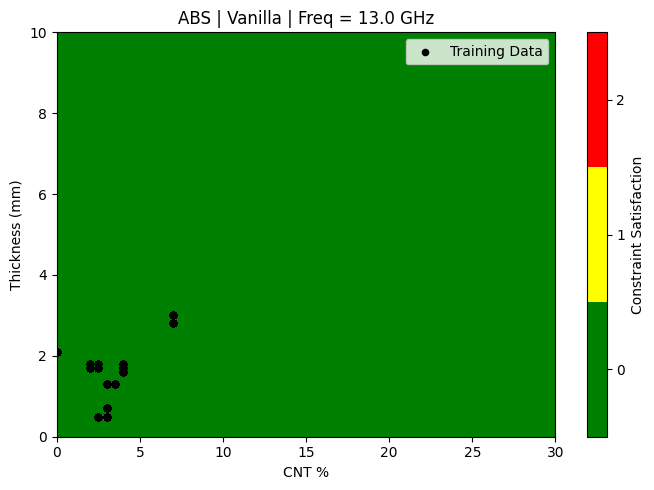

KeyboardInterrupt: 

In [39]:
def evaluate_sum_constraint(model, scaler, material_name, freq, model_name, is_gpytorch=False, df_ref=None, exclude_last_n=0):
    grid_x, grid_y = np.meshgrid(cnt_range, thickness_range)
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

    # Use average values from real data for epsilon_real and sigma
    epsilon_real_mean = df_ref["epsilon_real"].mean()
    sigma_mean = df_ref["sigma"].mean()

    inputs = np.column_stack([
        grid_points[:, 0],  # CNT%
        grid_points[:, 1],  # Thickness
        np.ones(len(grid_points)) * freq,  # Frequency
        np.ones(len(grid_points)) * epsilon_real_mean,
        np.ones(len(grid_points)) * sigma_mean
    ])

    inputs_scaled = scaler.transform(inputs)

    if is_gpytorch:
        X_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
        with torch.no_grad():
            pred = model(X_tensor)
            sum_outputs = pred.mean.sum(dim=1).numpy()
    else:
        sum_outputs = model.predict(inputs_scaled).sum(axis=1)

    error = np.abs(sum_outputs - 1)

    result = np.zeros_like(error)
    result[error <= perfect_tol] = 0  # Green
    result[(error > perfect_tol) & (error <= almost_tol)] = 1  # Yellow
    result[error > almost_tol] = 2  # Red

    result = result.reshape(grid_x.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(grid_x, grid_y, result, levels=[-0.5, 0.5, 1.5, 2.5], colors=['green', 'yellow', 'red'])
    plt.colorbar(ticks=[0, 1, 2], label='Constraint Satisfaction')

    # Plot only the used training points
    if exclude_last_n > 0:
        df_used = df_ref.iloc[:-exclude_last_n]
    else:
        df_used = df_ref

    plt.scatter(df_used["cnt_pct"], df_used["thickness"], c='black', s=20, label='Training Data')
    plt.legend()

    plt.title(f'{material_name} | {model_name} | Freq = {freq/1e9} GHz')
    plt.xlabel('CNT %')
    plt.ylabel('Thickness (mm)')
    plt.tight_layout()
    plt.show()
for model, scaler, material, model_name, is_gpytorch, df_ref, exclude_last_n in [
    (abs_gpr_vanilla['model'], abs_gpr_vanilla['model'].named_steps['standardscaler'], 'ABS', 'Vanilla', False, abs_r1, 18),
    (abs_model_r2, abs_scaler_r2, 'ABS', 'Round 2', True, abs_r1, 15),
    (abs_model_r3, abs_scaler_r3, 'ABS', 'Round 3', True, abs_r1, 0),
]:
    for freq in frequencies:
        evaluate_sum_constraint(model, scaler, material, freq, model_name, is_gpytorch, df_ref, exclude_last_n)

# Same for PBT
for model, scaler, material, model_name, is_gpytorch, df_ref, exclude_last_n in [
    (pbt_gpr_vanilla['model'], pbt_gpr_vanilla['model'].named_steps['standardscaler'], 'PBT', 'Vanilla', False, pbt_r1, 18),
    (pbt_model_r2, pbt_scaler_r2, 'PBT', 'Round 2', True, pbt_r1, 15),
    (pbt_model_r3, pbt_scaler_r3, 'PBT', 'Round 3', True, pbt_r1, 0),
]:
    for freq in frequencies:
        evaluate_sum_constraint(model, scaler, material, freq, model_name, is_gpytorch, df_ref, exclude_last_n)


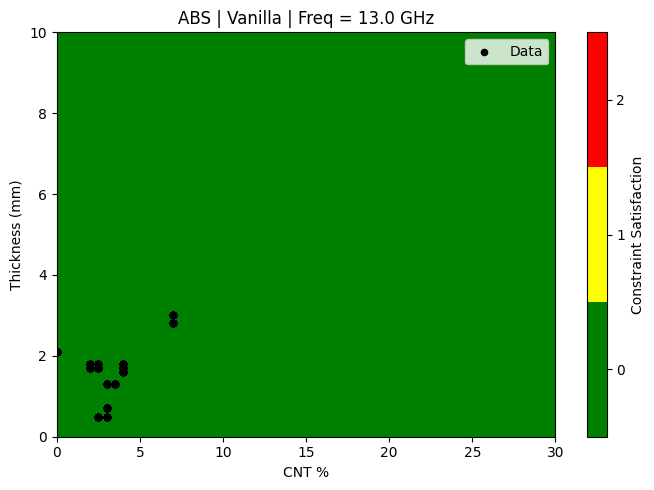

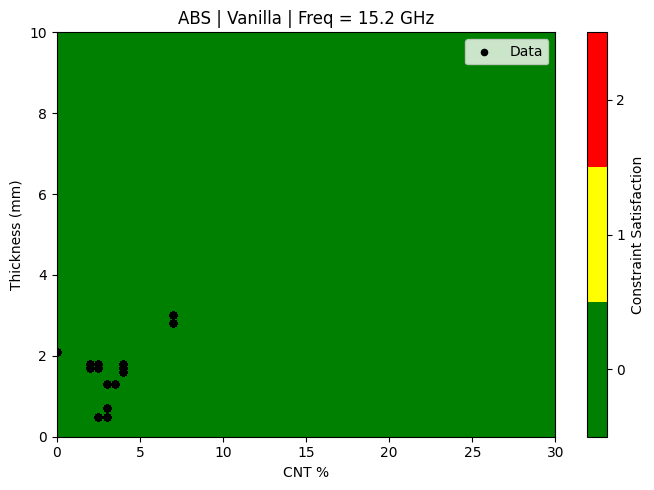

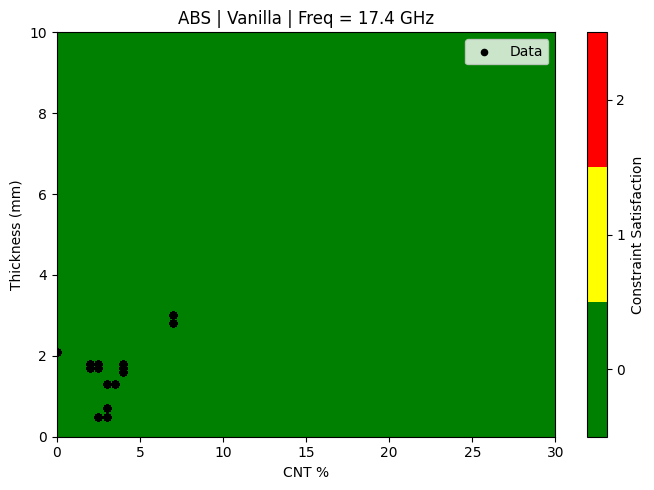

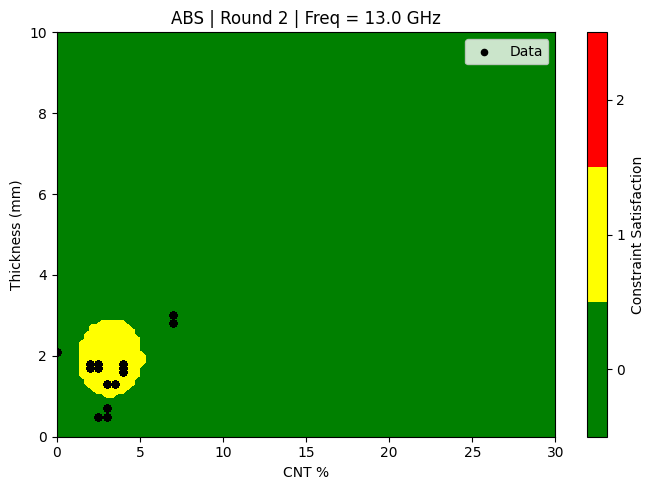

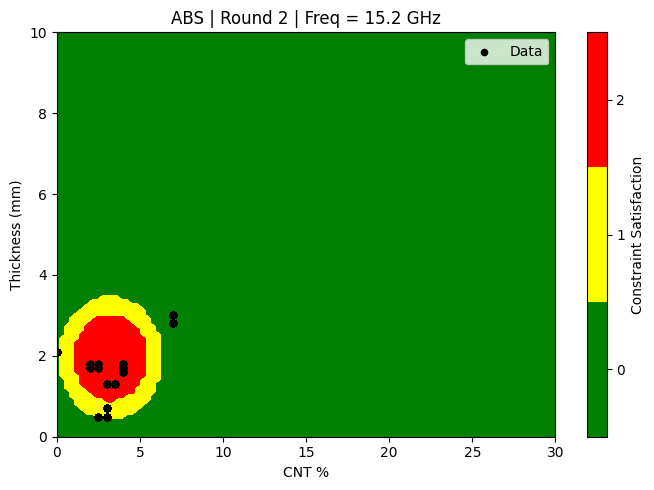

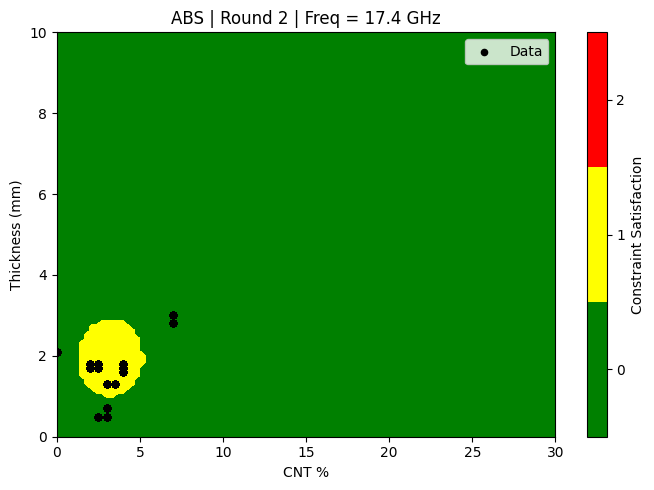

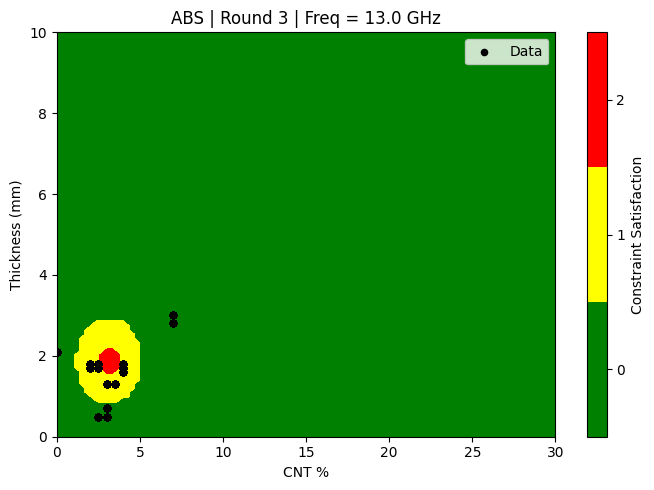

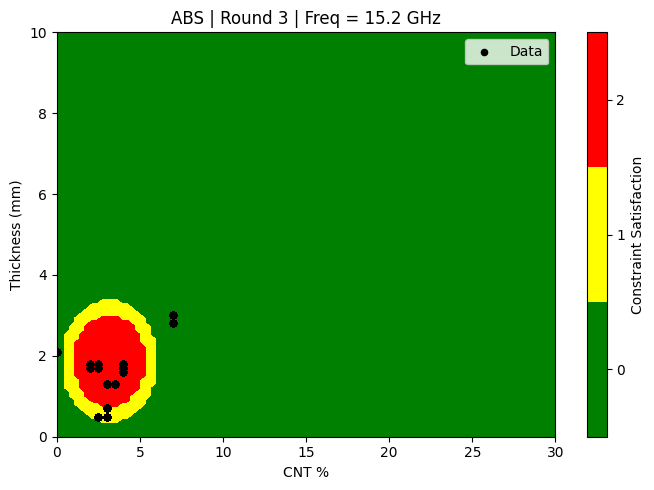

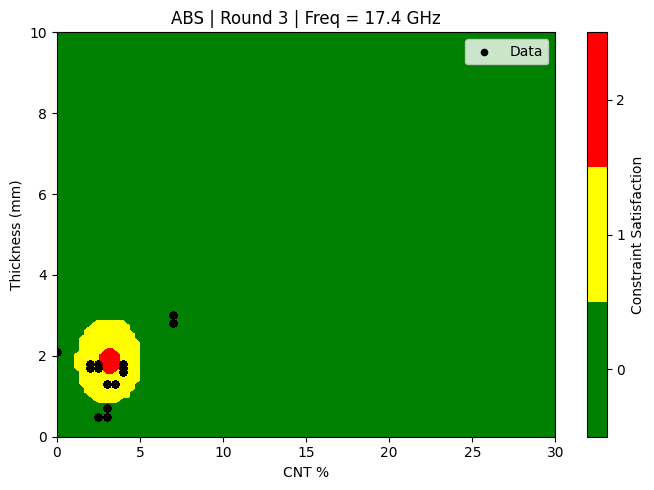

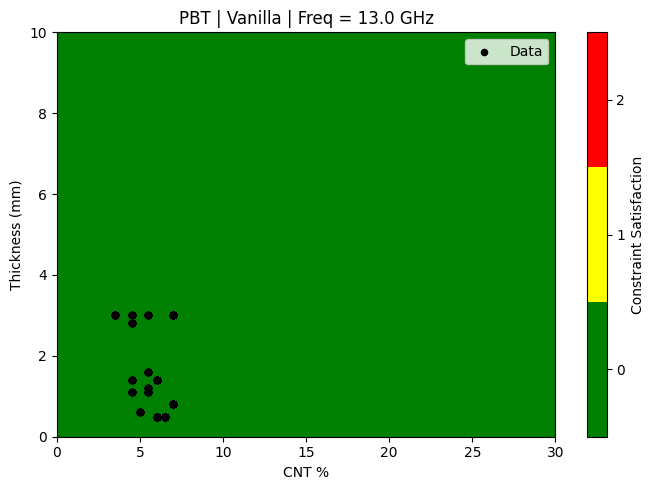

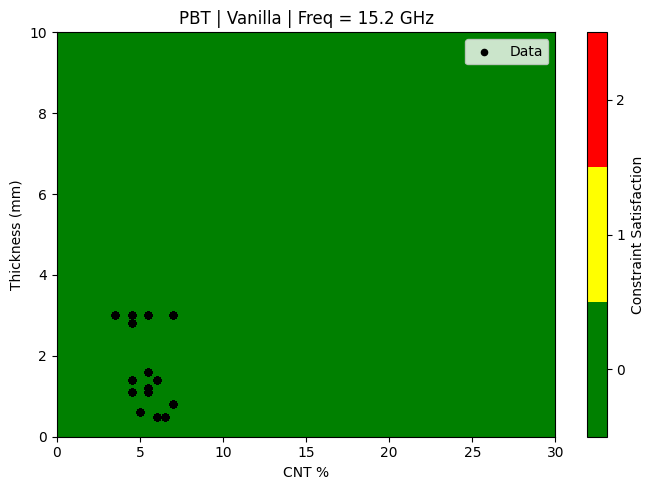

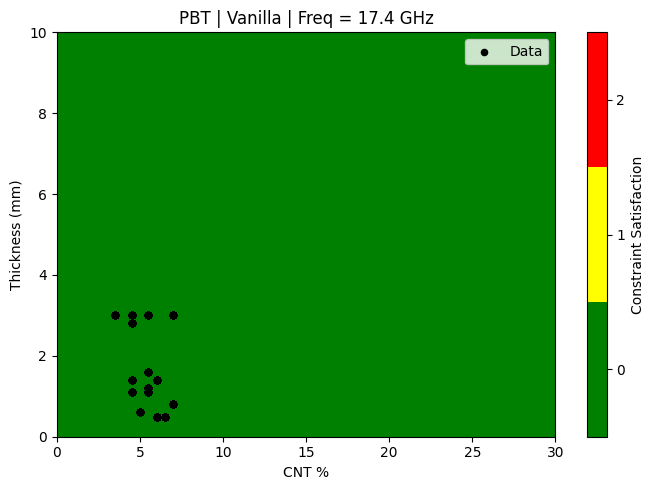

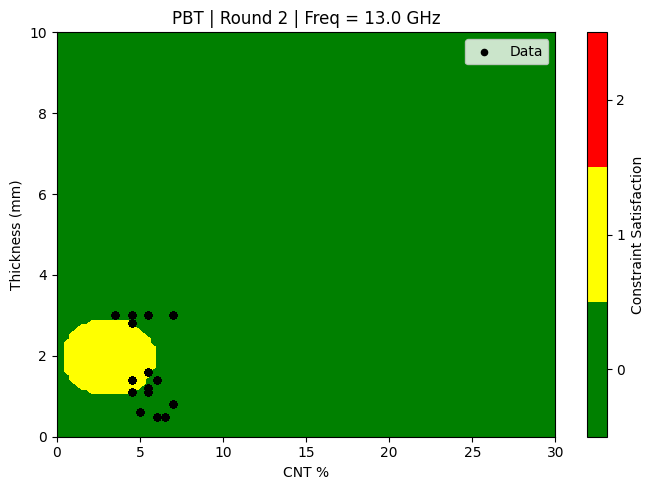

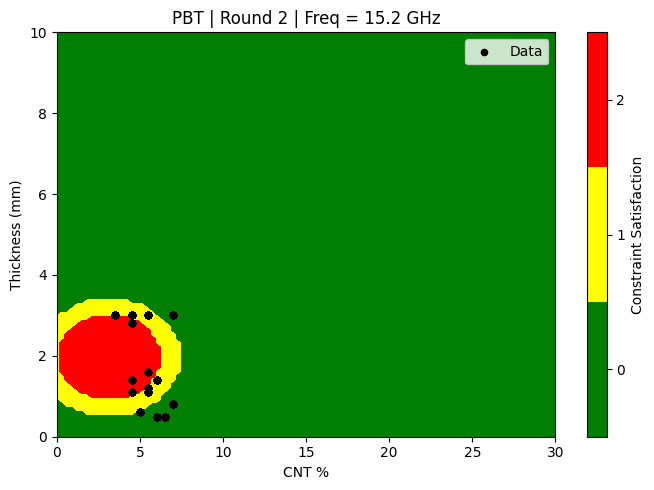

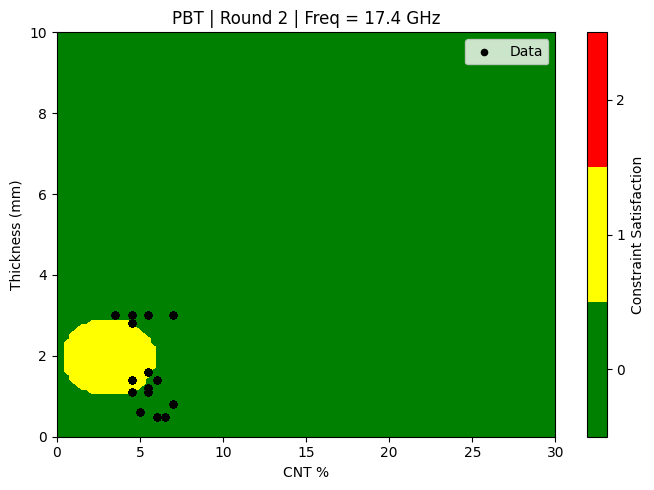

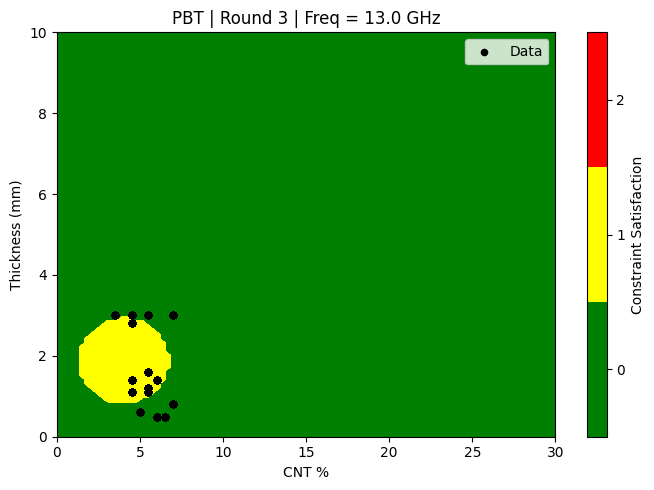

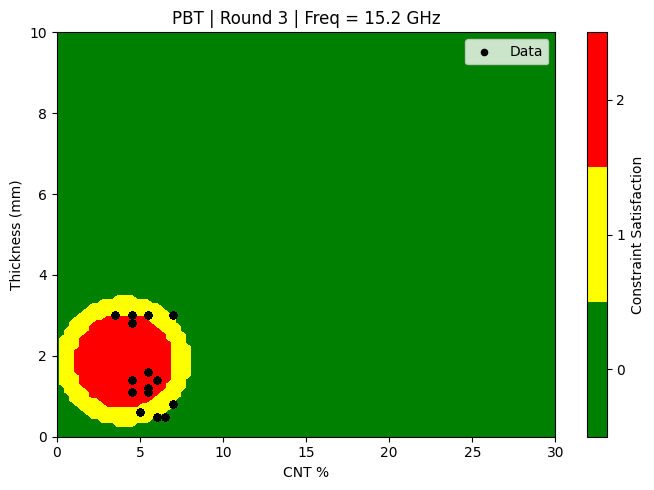

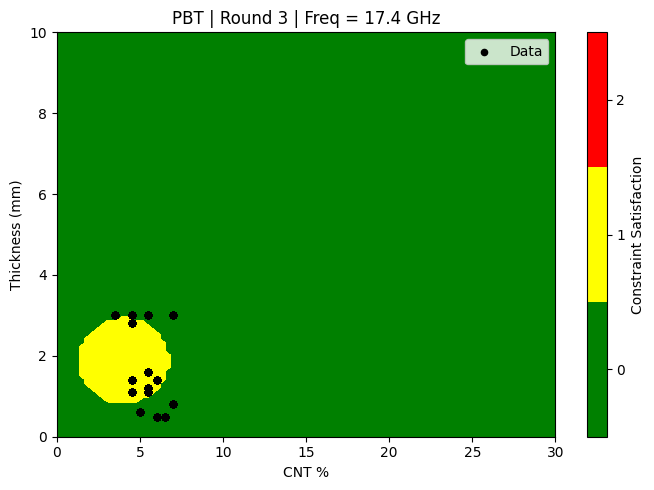

In [37]:
def evaluate_sum_constraint(model, scaler, material_name, freq, model_name, is_gpytorch=False, df_ref=None):
    grid_x, grid_y = np.meshgrid(cnt_range, thickness_range)
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

    # Take average from real data
    epsilon_real_mean = df_ref["epsilon_real"].mean()
    sigma_mean = df_ref["sigma"].mean()

    inputs = np.column_stack([
        grid_points[:, 0],  # CNT%
        grid_points[:, 1],  # Thickness
        np.ones(len(grid_points)) * freq,  # Frequency
        np.ones(len(grid_points)) * epsilon_real_mean,
        np.ones(len(grid_points)) * sigma_mean
    ])

    inputs_scaled = scaler.transform(inputs)

    if is_gpytorch:
        X_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
        with torch.no_grad():
            pred = model(X_tensor)
            sum_outputs = pred.mean.sum(dim=1).numpy()
    else:
        sum_outputs = model.predict(inputs_scaled).sum(axis=1)

    error = np.abs(sum_outputs - 1)

    result = np.zeros_like(error)
    result[error <= perfect_tol] = 0  # Green
    result[(error > perfect_tol) & (error <= almost_tol)] = 1  # Yellow
    result[error > almost_tol] = 2  # Red

    result = result.reshape(grid_x.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(grid_x, grid_y, result, levels=[-0.5, 0.5, 1.5, 2.5], colors=['green', 'yellow', 'red'])
    plt.colorbar(ticks=[0, 1, 2], label='Constraint Satisfaction')
    plt.scatter(df_ref["cnt_pct"], df_ref["thickness"], c='black', s=20, label='Data')
    plt.legend()
    plt.title(f'{material_name} | {model_name} | Freq = {freq/1e9} GHz')
    plt.xlabel('CNT %')
    plt.ylabel('Thickness (mm)')
    plt.tight_layout()
    plt.show()
# For ABS
for model, scaler, material, model_name, is_gpytorch, df_ref in [
    (abs_gpr_vanilla['model'], abs_gpr_vanilla['model'].named_steps['standardscaler'], 'ABS', 'Vanilla', False, abs_r1),
    (abs_model_r2, abs_scaler_r2, 'ABS', 'Round 2', True, abs_r1),
    (abs_model_r3, abs_scaler_r3, 'ABS', 'Round 3', True, abs_r1),
]:
    for freq in frequencies:
        evaluate_sum_constraint(model, scaler, material, freq, model_name, is_gpytorch, df_ref)

# For PBT
for model, scaler, material, model_name, is_gpytorch, df_ref in [
    (pbt_gpr_vanilla['model'], pbt_gpr_vanilla['model'].named_steps['standardscaler'], 'PBT', 'Vanilla', False, pbt_r1),
    (pbt_model_r2, pbt_scaler_r2, 'PBT', 'Round 2', True, pbt_r1),
    (pbt_model_r3, pbt_scaler_r3, 'PBT', 'Round 3', True, pbt_r1),
]:
    for freq in frequencies:
        evaluate_sum_constraint(model, scaler, material, freq, model_name, is_gpytorch, df_ref)


In [43]:
import numpy as np
import pandas as pd
import torch

# Define your grid ranges
thickness_range = np.linspace(0, 10, 30)  # mm
cnt_range = np.linspace(0, 30, 30)        # %

# Frequencies of interest
frequencies = [13e9, 15.2e9, 17.4e9]

# Function to calculate uncertainty and loss
def evaluate_model_uncertainty_and_loss(model, scaler, df_ref, freq_list, is_gpytorch=True):
    metrics = []

    grid_x, grid_y = np.meshgrid(cnt_range, thickness_range)
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

    # Use dataset average for these values
    epsilon_real_mean = df_ref["epsilon_real"].mean()
    sigma_mean = df_ref["sigma"].mean()

    for freq in freq_list:
        inputs = np.column_stack([
            grid_points[:, 0],  # CNT %
            grid_points[:, 1],  # Thickness
            np.ones(len(grid_points)) * freq,
            np.ones(len(grid_points)) * epsilon_real_mean,
            np.ones(len(grid_points)) * sigma_mean
        ])

        inputs_scaled = scaler.transform(inputs)

        if is_gpytorch:
            model.eval()
            with torch.no_grad():
                X_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)
                pred = model(X_tensor)
                mean = pred.mean.numpy()
                var = pred.variance.numpy()
        else:
            mean = model.predict(inputs_scaled)
            var = np.zeros_like(mean)  # No uncertainty for sklearn model

        mse = np.mean((mean - 1/3) ** 2, axis=0)
        avg_uncertainty = np.mean(var, axis=0)

        metrics.append({
            "Frequency (GHz)": freq / 1e9,
            "Absorption MSE": mse[0],
            "Reflection MSE": mse[1],
            "Transmission MSE": mse[2],
            "Absorption Uncertainty": avg_uncertainty[0],
            "Reflection Uncertainty": avg_uncertainty[1],
            "Transmission Uncertainty": avg_uncertainty[2],
        })

    return pd.DataFrame(metrics)
# ABS Models
abs_metrics_r2 = evaluate_model_uncertainty_and_loss(abs_model_r2, abs_scaler_r2, abs_r1, frequencies, is_gpytorch=True)
abs_metrics_r3 = evaluate_model_uncertainty_and_loss(abs_model_r3, abs_scaler_r3, abs_r1, frequencies, is_gpytorch=True)

# PBT Models
pbt_metrics_r2 = evaluate_model_uncertainty_and_loss(pbt_model_r2, pbt_scaler_r2, pbt_r1, frequencies, is_gpytorch=True)
pbt_metrics_r3 = evaluate_model_uncertainty_and_loss(pbt_model_r3, pbt_scaler_r3, pbt_r1, frequencies, is_gpytorch=True)

# Vanilla (Sklearn)
abs_metrics_vanilla = evaluate_model_uncertainty_and_loss(abs_gpr_vanilla['model'], abs_gpr_vanilla['model'].named_steps['standardscaler'], abs_r1, frequencies, is_gpytorch=False)
pbt_metrics_vanilla = evaluate_model_uncertainty_and_loss(pbt_gpr_vanilla['model'], pbt_gpr_vanilla['model'].named_steps['standardscaler'], pbt_r1, frequencies, is_gpytorch=False)


In [46]:
abs_metrics_vanilla

Frequency (GHz)  Absorption MSE  Reflection MSE  Transmission MSE  \
0             13.0        0.000718        0.099707          0.082445   
1             15.2        0.000718        0.099707          0.082445   
2             17.4        0.000718        0.099707          0.082445   

   Absorption Uncertainty  Reflection Uncertainty  Transmission Uncertainty  
0                     0.0                     0.0                       0.0  
1                     0.0                     0.0                       0.0  
2                     0.0                     0.0                       0.0

In [44]:
abs_metrics_r2

Frequency (GHz)  Absorption MSE  Reflection MSE  Transmission MSE  \
0             13.0        0.000745        0.062404          0.076976   
1             15.2        0.000732        0.061718          0.077240   
2             17.4        0.000745        0.062404          0.076976   

   Absorption Uncertainty  Reflection Uncertainty  Transmission Uncertainty  
0                0.383612                0.436301                  0.579923  
1                0.383063                0.435585                  0.578772  
2                0.383612                0.436301                  0.579923

In [45]:
abs_metrics_r3

Frequency (GHz)  Absorption MSE  Reflection MSE  Transmission MSE  \
0             13.0        0.000647        0.069427          0.083770   
1             15.2        0.000644        0.068517          0.084154   
2             17.4        0.000647        0.069427          0.083770   

   Absorption Uncertainty  Reflection Uncertainty  Transmission Uncertainty  
0                0.320734                0.867749                  0.859433  
1                0.320361                0.865854                  0.857551  
2                0.320734                0.867749                  0.859433

<Figure size 1000x500 with 0 Axes>

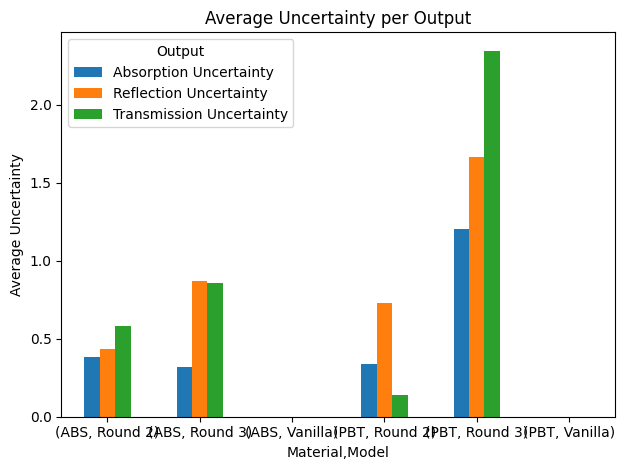

<Figure size 1000x500 with 0 Axes>

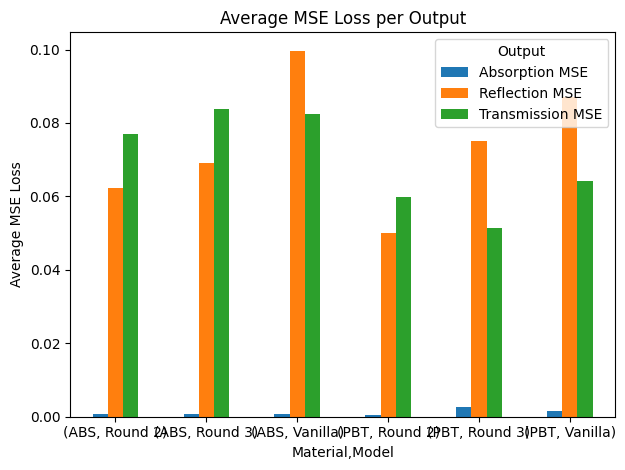

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all metrics into one DataFrame
all_metrics = (
    abs_metrics_vanilla + pbt_metrics_vanilla +
    abs_metrics_r2 + pbt_metrics_r2 +
    abs_metrics_r3 + pbt_metrics_r3
)

metrics_df = pd.DataFrame(all_metrics)

# Plot 1: MSE vs Frequency for each Material & Round
def plot_mse_vs_freq(metrics_df, material, round_name):
    subset = metrics_df[(metrics_df['material'] == material) & (metrics_df['Model'] == round_name)]
    plt.figure(figsize=(8, 5))
    for target in ['absorption', 'reflection', 'transmission']:
        df_target = subset[subset['Output'] == target]
        plt.plot(df_target['Frequency'], df_target['MSE'], marker='o', label=target.capitalize())
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('MSE')
    plt.title(f'{material} | {round_name}: MSE vs Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 2: Uncertainty vs Frequency for each Material & Round
def plot_uncertainty_vs_freq(metrics_df, material, round_name):
    subset = metrics_df[(metrics_df['Material'] == material) & (metrics_df['Model'] == round_name)]
    plt.figure(figsize=(8, 5))
    for target in ['absorption', 'reflection', 'transmission']:
        df_target = subset[subset['Output'] == target]
        plt.plot(df_target['Frequency'], df_target['Uncertainty'], marker='s', label=target.capitalize())
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Average Uncertainty')
    plt.title(f'{material} | {round_name}: Uncertainty vs Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot 3: Average Uncertainty per Round per Output
def plot_avg_uncertainty_per_round(metrics_df, material):
    subset = metrics_df[metrics_df['Material'] == material]
    avg_uncertainty = subset.groupby(['Model', 'Output'])['Uncertainty'].mean().reset_index()
    pivot_df = avg_uncertainty.pivot(index='Model', columns='Output', values='Uncertainty')

    pivot_df.plot(kind='bar', figsize=(10, 6))
    plt.title(f'{material} | Avg Uncertainty Per Round')
    plt.ylabel('Average Uncertainty')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Organize your metrics variables
metrics_data = [
    (abs_metrics_vanilla, 'ABS', 'Vanilla'),
    (abs_metrics_r2, 'ABS', 'Round 2'),
    (abs_metrics_r3, 'ABS', 'Round 3'),
    (pbt_metrics_vanilla, 'PBT', 'Vanilla'),
    (pbt_metrics_r2, 'PBT', 'Round 2'),
    (pbt_metrics_r3, 'PBT', 'Round 3'),
]

dfs = []

# Step 2: Add Material and Model Columns
for df, material, model in metrics_data:
    temp_df = df.copy()
    temp_df['Material'] = material
    temp_df['Model'] = model
    dfs.append(temp_df)

# Step 3: Combine into a single dataframe
metrics_df = pd.concat(dfs, ignore_index=True)

# Step 4: Reshape Data for Uncertainty Plot
uncertainty_df = metrics_df.melt(
    id_vars=['Frequency (GHz)', 'Material', 'Model'],
    value_vars=['Absorption Uncertainty', 'Reflection Uncertainty', 'Transmission Uncertainty'],
    var_name='Output',
    value_name='Uncertainty'
)

# Step 5: Reshape Data for Loss Plot
loss_df = metrics_df.melt(
    id_vars=['Frequency (GHz)', 'Material', 'Model'],
    value_vars=['Absorption MSE', 'Reflection MSE', 'Transmission MSE'],
    var_name='Output',
    value_name='MSE'
)

# === Plot Average Uncertainty ===
plt.figure(figsize=(10, 5))
uncertainty_df.groupby(['Material', 'Model', 'Output'])['Uncertainty'].mean().unstack().plot(kind='bar')
plt.ylabel('Average Uncertainty')
plt.title('Average Uncertainty per Output')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# === Plot Average Loss (MSE) ===
plt.figure(figsize=(10, 5))
loss_df.groupby(['Material', 'Model', 'Output'])['MSE'].mean().unstack().plot(kind='bar')
plt.ylabel('Average MSE Loss')
plt.title('Average MSE Loss per Output')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




<ipython-input-53-386fbc773468>:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Absorption MSE": avg_mse[0],
<ipython-input-53-386fbc773468>:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Reflection MSE": avg_mse[1],
<ipython-input-53-386fbc773468>:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "Transmission MSE": avg_mse[2],
<ipython-input-53-386fbc773468>:33: FutureWarning: Series.__getitem__ treating keys as positions i

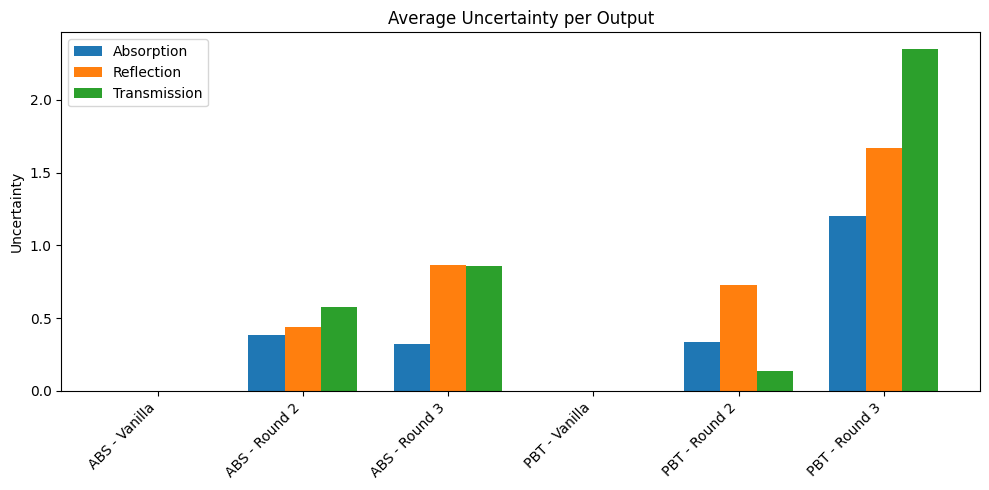

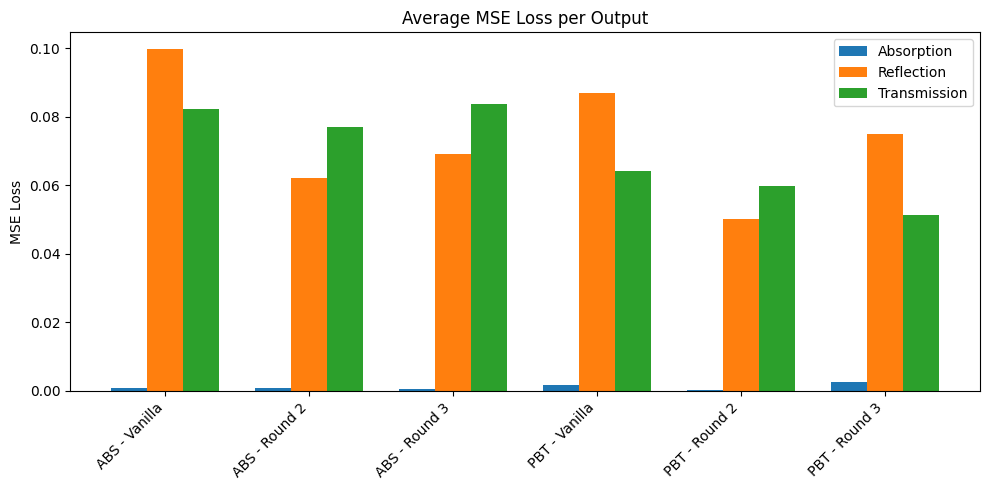

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Combine All Metrics ===
metrics_combined = {
    'ABS': {
        'Vanilla': abs_metrics_vanilla,
        'Round 2': abs_metrics_r2,
        'Round 3': abs_metrics_r3
    },
    'PBT': {
        'Vanilla': pbt_metrics_vanilla,
        'Round 2': pbt_metrics_r2,
        'Round 3': pbt_metrics_r3
    }
}

# === Prepare Summary DataFrame ===
summary_data = []

for material, model_dict in metrics_combined.items():
    for model_name, df in model_dict.items():
        avg_mse = df[["Absorption MSE", "Reflection MSE", "Transmission MSE"]].mean()
        avg_uncertainty = df[["Absorption Uncertainty", "Reflection Uncertainty", "Transmission Uncertainty"]].mean()

        summary_data.append({
            "Material": material,
            "Model": model_name,
            "Absorption MSE": avg_mse[0],
            "Reflection MSE": avg_mse[1],
            "Transmission MSE": avg_mse[2],
            "Absorption Uncertainty": avg_uncertainty[0],
            "Reflection Uncertainty": avg_uncertainty[1],
            "Transmission Uncertainty": avg_uncertainty[2],
        })

summary_df = pd.DataFrame(summary_data)

# === Ensure Correct Order ===
category_order = ["Vanilla", "Round 2", "Round 3"]
summary_df["Model"] = pd.Categorical(summary_df["Model"], categories=category_order, ordered=True)
summary_df = summary_df.sort_values(by=["Material", "Model"])

# === Plotting Function ===
def plot_metrics(summary_df, metric_prefix, ylabel):
    labels = [f"{row['Material']} - {row['Model']}" for idx, row in summary_df.iterrows()]
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 5))

    ax.bar(x - width, summary_df[f"{metric_prefix} Absorption"], width, label='Absorption')
    ax.bar(x, summary_df[f"{metric_prefix} Reflection"], width, label='Reflection')
    ax.bar(x + width, summary_df[f"{metric_prefix} Transmission"], width, label='Transmission')

    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(ylabel)
    ax.set_title(f"Average {ylabel} per Output")
    ax.legend()
    plt.tight_layout()
    plt.show()

# === Plot Uncertainty ===
plot_metrics(summary_df.rename(columns={
    "Absorption Uncertainty": "Uncertainty Absorption",
    "Reflection Uncertainty": "Uncertainty Reflection",
    "Transmission Uncertainty": "Uncertainty Transmission",
}), metric_prefix="Uncertainty", ylabel="Uncertainty")

# === Plot MSE ===
plot_metrics(summary_df.rename(columns={
    "Absorption MSE": "MSE Absorption",
    "Reflection MSE": "MSE Reflection",
    "Transmission MSE": "MSE Transmission",
}), metric_prefix="MSE", ylabel="MSE Loss")


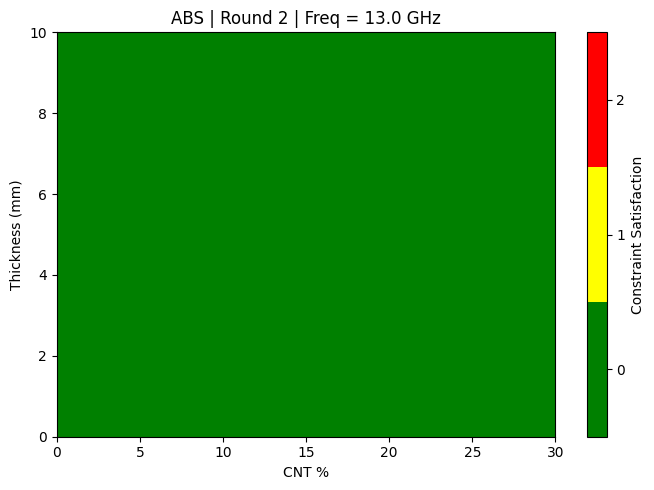

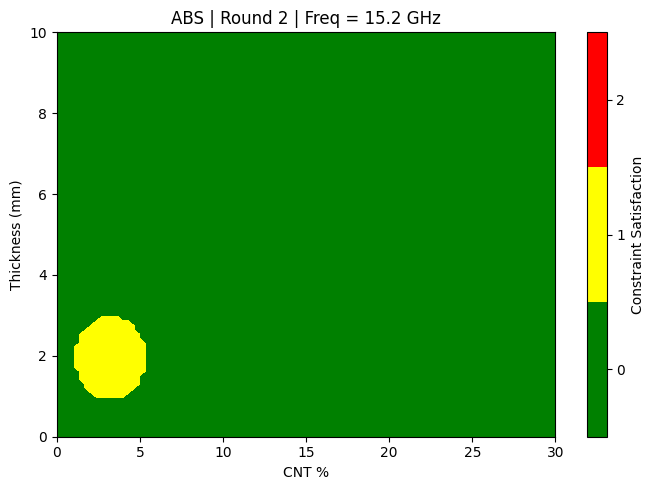

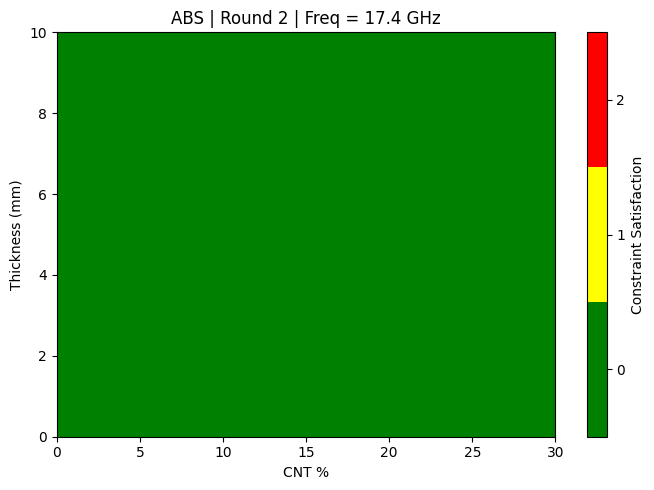

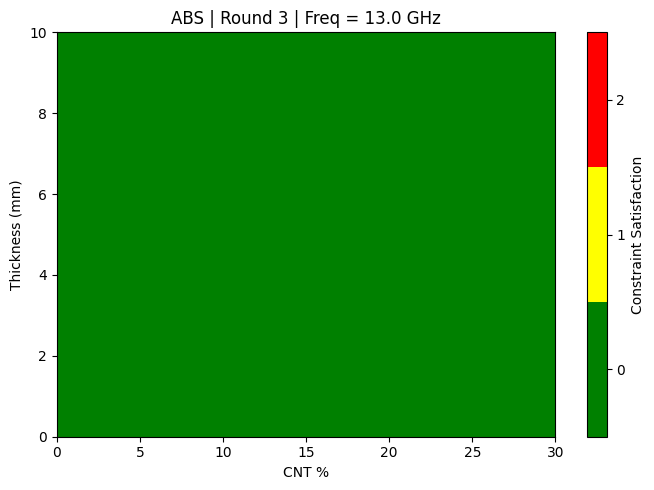

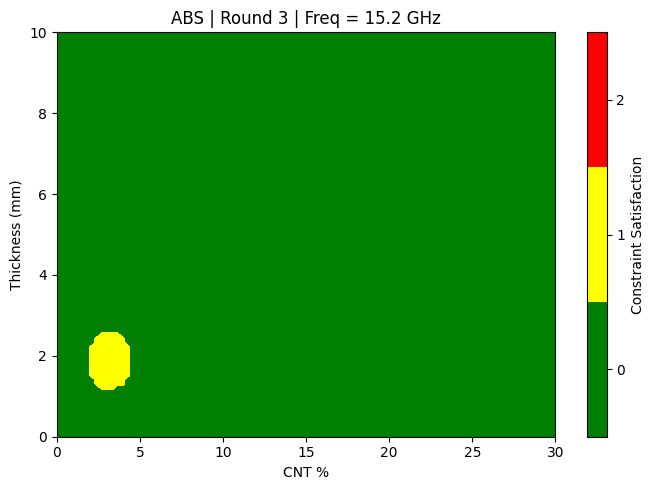

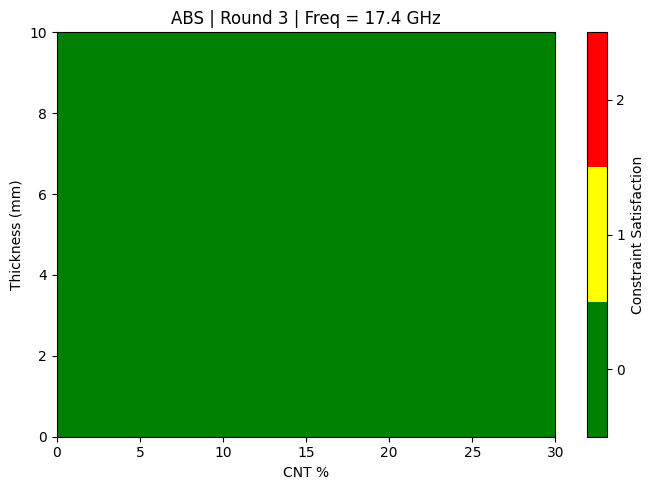

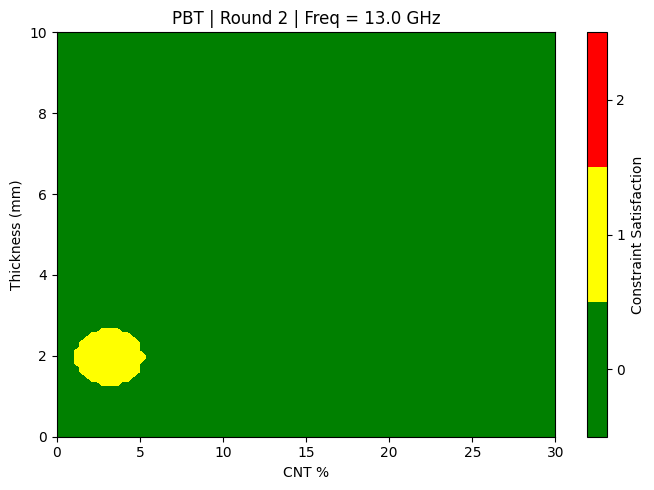

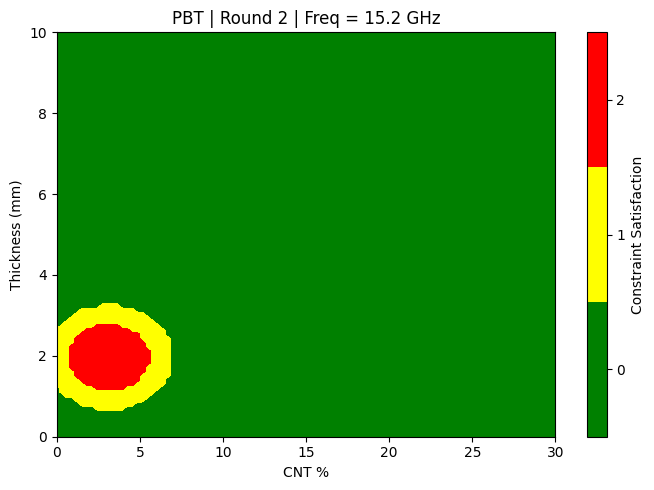

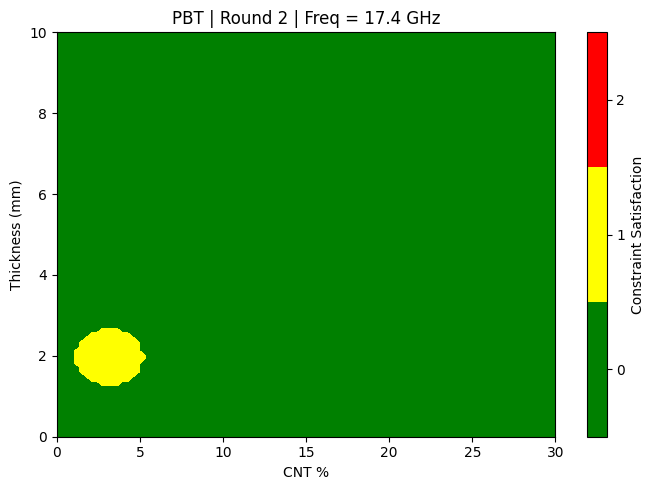

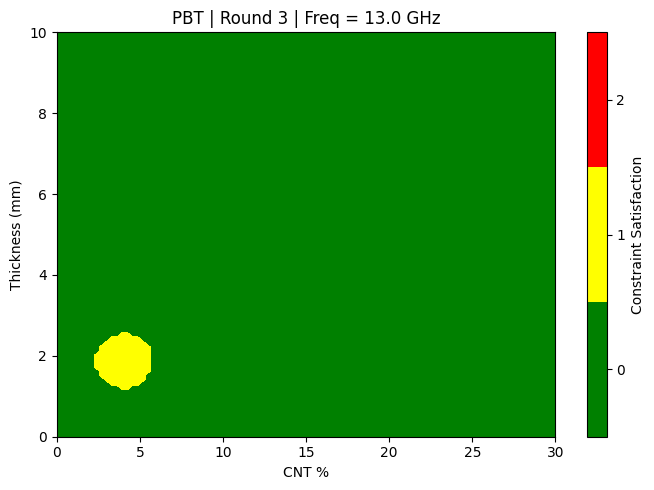

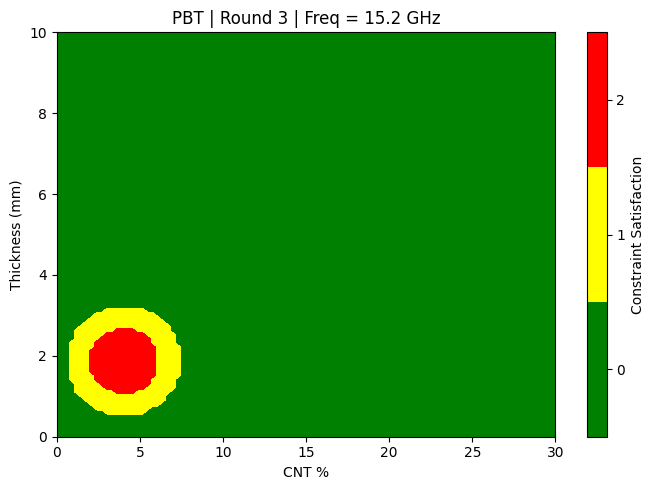

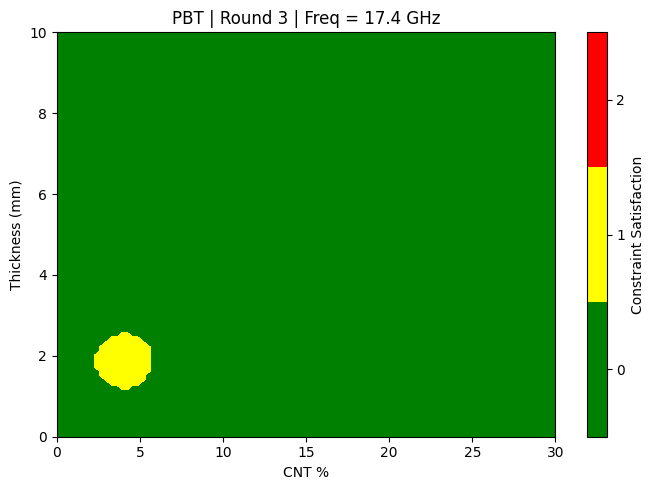

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import joblib

# Define grid for thickness and CNT%
thickness_range = np.linspace(0, 10, 100)  # 0mm to 10mm
cnt_range = np.linspace(0, 30, 100)  # 0% to 30% CNT

# Frequencies to test
frequencies = [13e9, 15.2e9, 17.4e9]  # Hz

perfect_tol = 0.01  # within 1%
almost_tol = 0.05  # within 5%

def evaluate_sum_constraint(model, scaler, material_name, freq, model_name):
    grid_x, grid_y = np.meshgrid(cnt_range, thickness_range)
    grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]

    # Add dummy values for epsilon_real and sigma
    epsilon_real_dummy = np.ones(len(grid_points)) * 2
    sigma_dummy = np.ones(len(grid_points)) * 0.1

    inputs = np.column_stack([
        grid_points[:, 0],  # CNT%
        grid_points[:, 1],  # Thickness
        np.ones(len(grid_points)) * freq,  # Frequency
        epsilon_real_dummy,
        sigma_dummy
    ])

    inputs_scaled = scaler.transform(inputs)
    X_tensor = torch.tensor(inputs_scaled, dtype=torch.float32)

    with torch.no_grad():
        pred = model(X_tensor)
        sum_outputs = pred.mean.sum(dim=1).numpy()

    error = np.abs(sum_outputs - 1)

    result = np.zeros_like(error)
    result[error <= perfect_tol] = 0  # Green
    result[(error > perfect_tol) & (error <= almost_tol)] = 1  # Yellow
    result[error > almost_tol] = 2  # Red

    result = result.reshape(grid_x.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(grid_x, grid_y, result, levels=[-0.5, 0.5, 1.5, 2.5], colors=['green', 'yellow', 'red'])
    plt.colorbar(ticks=[0, 1, 2], label='Constraint Satisfaction')
    plt.title(f'{material_name} | {model_name} | Freq = {freq/1e9} GHz')
    plt.xlabel('CNT %')
    plt.ylabel('Thickness (mm)')
    plt.tight_layout()
    plt.show()


# Example Usage:
# Repeat this for:
# [abs_model_vanilla, abs_scaler_vanilla, 'ABS', 'Vanilla']
# [abs_model_r2, abs_scaler_r2, 'ABS', 'Round 2']
# [abs_model_r3, abs_scaler_r3, 'ABS', 'Round 3']
# and same for PBT

# Example Run:
for model, scaler, material, model_name in [
    #(abs_gpr_vanilla, abs_scaler_vanilla, 'ABS', 'Vanilla'),
    (abs_model_r2, abs_scaler_r2, 'ABS', 'Round 2'),
    (abs_model_r3, abs_scaler_r3, 'ABS', 'Round 3'),
    #(pbt_model_vanilla, pbt_scaler_vanilla, 'PBT', 'Vanilla'),
    (pbt_model_r2, pbt_scaler_r2, 'PBT', 'Round 2'),
    (pbt_model_r3, pbt_scaler_r3, 'PBT', 'Round 3'),
]:
    for freq in frequencies:
        evaluate_sum_constraint(model, scaler, material, freq, model_name)


In [25]:
import torch
import gpytorch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import numpy as np

# === Helper to prepare data ===
def prepare_tensors(df):
    X = df[input_features].values.astype(np.float32)
    y = df[output_targets].values.astype(np.float32)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return torch.tensor(X_scaled), torch.tensor(y), scaler

# === Step 2: GPR Model ===
class ExactMultiOutputGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
            ), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)

# === Step 3: Custom loss enforcing 0≤A,R,T≤1 and A+R+T≈1 ===
def custom_loss(pred, target):
    mse = torch.nn.functional.mse_loss(pred.mean, target)

    # Constraint: A + R + T ≈ 1
    sum_penalty = torch.mean((torch.sum(pred.mean, dim=1) - 1.0)**2)

    # Constraint: Each value should be in [0, 1]
    clip_penalty = torch.mean(torch.clamp(pred.mean - 1.0, min=0)**2 + torch.clamp(-pred.mean, min=0)**2)

    return mse + 10.0 * sum_penalty + 5.0 * clip_penalty

def train_gpr_model_pytorch(X, y, num_epochs=200, lr=0.1):
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
    model = ExactMultiOutputGPModel(X, y, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = custom_loss(output, y)
        loss.backward()
        if i % 20 == 0:
            print(f"Epoch {i} - Loss: {loss.item():.4f}")
        optimizer.step()

    return model.eval(), likelihood.eval()



In [26]:
import os
import joblib
import torch

def save_gpr_model(model, likelihood, scaler, save_prefix="ABS"):
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), f"saved_models/{save_prefix}_gp_model.pth")
    torch.save(likelihood.state_dict(), f"saved_models/{save_prefix}_likelihood.pth")
    joblib.dump(scaler, f"saved_models/{save_prefix}_scaler.pkl")
    print(f"✅ Saved model, likelihood, and scaler for {save_prefix}")


In [27]:
X_abs, y_abs, scaler_abs = prepare_tensors(abs_combined)
abs_model, abs_likelihood = train_gpr_model_pytorch(X_abs, y_abs)
save_gpr_model(abs_model, abs_likelihood, scaler_abs, save_prefix="ABS")


Epoch 0 - Loss: 10.1800
Epoch 20 - Loss: 0.5834
Epoch 40 - Loss: 0.1110
Epoch 60 - Loss: 0.0304
Epoch 80 - Loss: 0.0217
Epoch 100 - Loss: 0.0166
Epoch 120 - Loss: 0.0146
Epoch 140 - Loss: 0.0137
Epoch 160 - Loss: 0.0134
Epoch 180 - Loss: 0.0133
✅ Saved model, likelihood, and scaler for ABS


In [28]:
# Prepare PBT data
X_pbt, y_pbt, scaler_pbt = prepare_tensors(pbt_combined)

# Train PBT model
pbt_model, pbt_likelihood = train_gpr_model_pytorch(X_pbt, y_pbt)

# Save PBT model
save_gpr_model(pbt_model, pbt_likelihood, scaler_pbt, save_prefix="PBT")


Epoch 0 - Loss: 10.1786
Epoch 20 - Loss: 0.5879
Epoch 40 - Loss: 0.1185
Epoch 60 - Loss: 0.0399
Epoch 80 - Loss: 0.0325
Epoch 100 - Loss: 0.0279
Epoch 120 - Loss: 0.0263
Epoch 140 - Loss: 0.0255
Epoch 160 - Loss: 0.0253
Epoch 180 - Loss: 0.0252
✅ Saved model, likelihood, and scaler for PBT


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import gpytorch

# Average values for other input features
def get_fixed_inputs(df):
    return {
        'frequency': df['frequency'].mean(),
        'epsilon_real': df['epsilon_real'].mean(),
        'sigma': df['sigma'].mean()
    }

# Generate CNT/Thickness grid and predictions
def generate_surface_data(model, scaler, fixed_inputs, grid_res=30):
    cnt_range = np.linspace(0, 7, grid_res)
    thickness_range = np.linspace(0.5, 3.0, grid_res)
    cnt_grid, thick_grid = np.meshgrid(cnt_range, thickness_range)

    X_grid = np.column_stack([
        cnt_grid.ravel(),
        thick_grid.ravel(),
        np.full(cnt_grid.size, fixed_inputs['frequency']),
        np.full(cnt_grid.size, fixed_inputs['epsilon_real']),
        np.full(cnt_grid.size, fixed_inputs['sigma'])
    ])

    X_scaled = scaler.transform(X_grid.astype(np.float32))
    X_torch = torch.tensor(X_scaled)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model(X_torch)
        means = preds.mean.numpy()  # Shape: [n_points, 3]

    return cnt_grid, thick_grid, means
def plot_surface_with_data(cnt_grid, thick_grid, predicted_values, train_df, target_label, material_name):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Index of the output target
    target_map = {"A": 0, "R": 1, "T": 2}
    target_index = target_map[target_label]

    # Surface values
    surface = predicted_values[:, target_index].reshape(cnt_grid.shape)

    # Surface plot
    surf = ax.plot_surface(cnt_grid, thick_grid, surface, cmap='viridis', alpha=0.75)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    # Overlay actual training points
    ax.scatter(train_df["cnt_pct"], train_df["thickness"], train_df[target_label],
               c='red', s=30, label="Training Data", depthshade=True)

    ax.set_xlabel("CNT %")
    ax.set_ylabel("Thickness (mm)")
    ax.set_zlabel(target_label)
    ax.set_title(f"{material_name} - {target_label} Surface (GPR)")
    ax.legend()
    plt.tight_layout()
    plt.show()


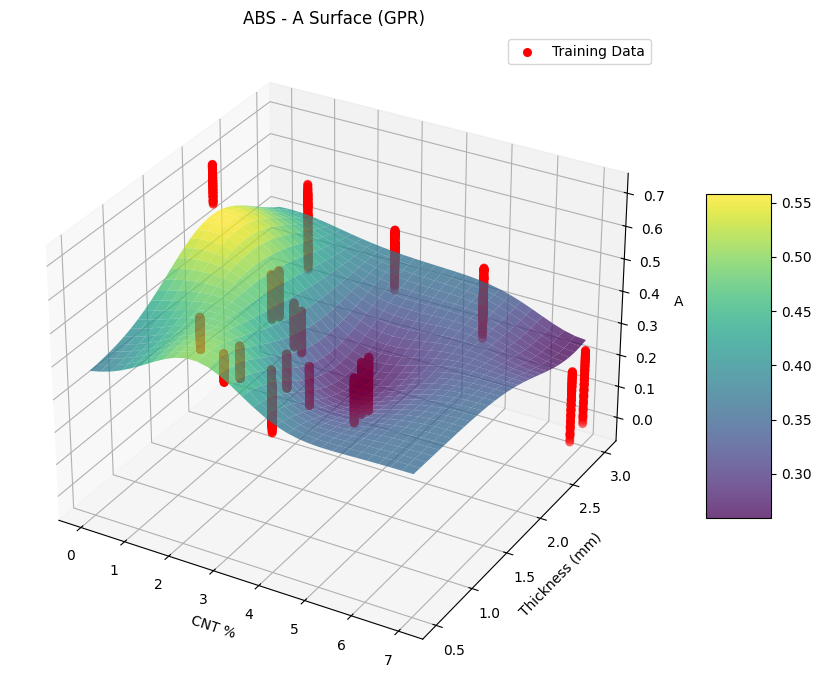

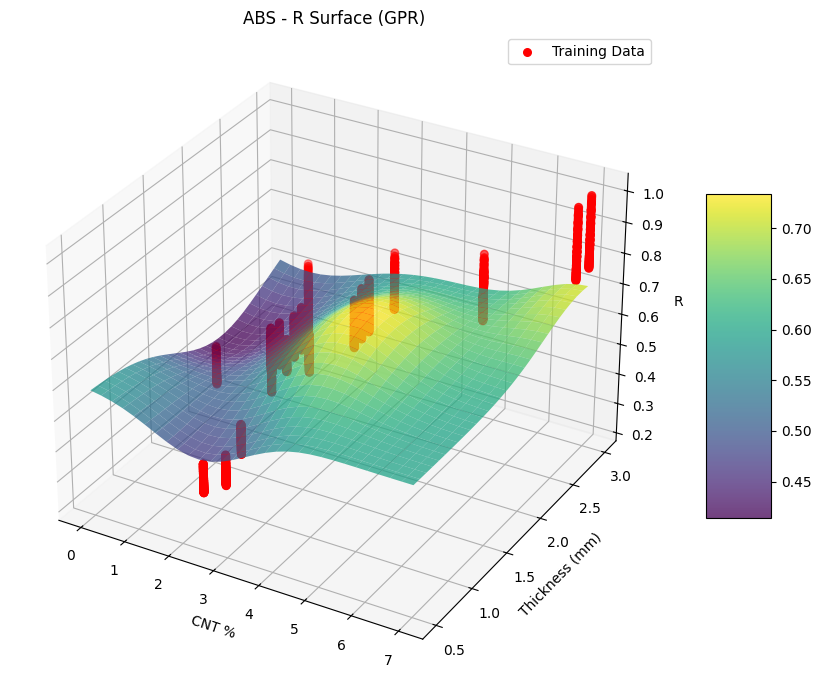

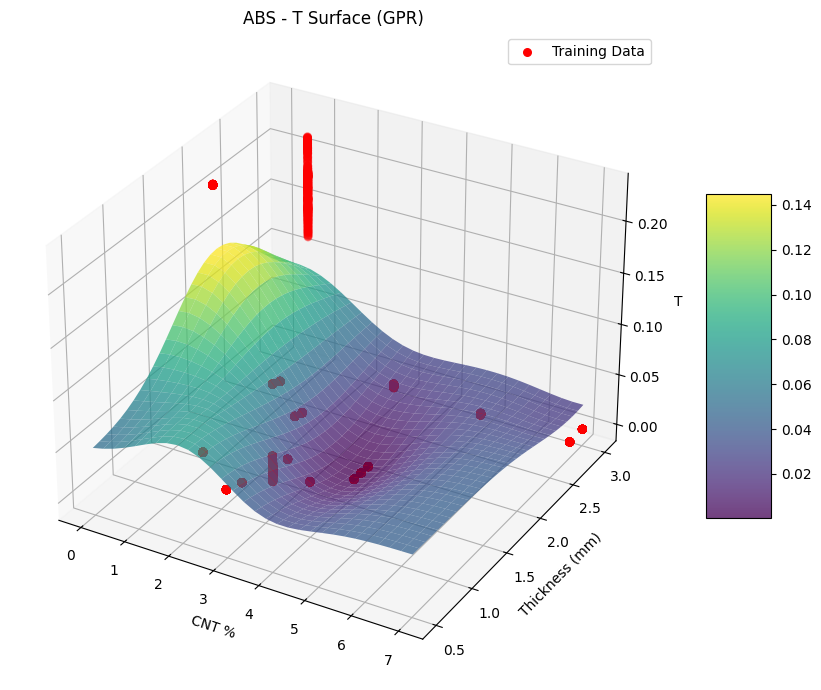

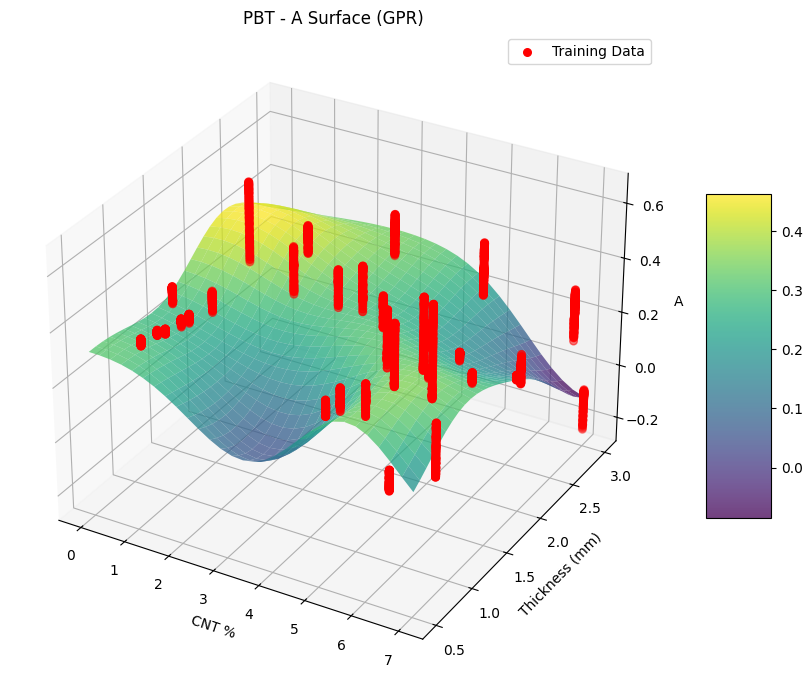

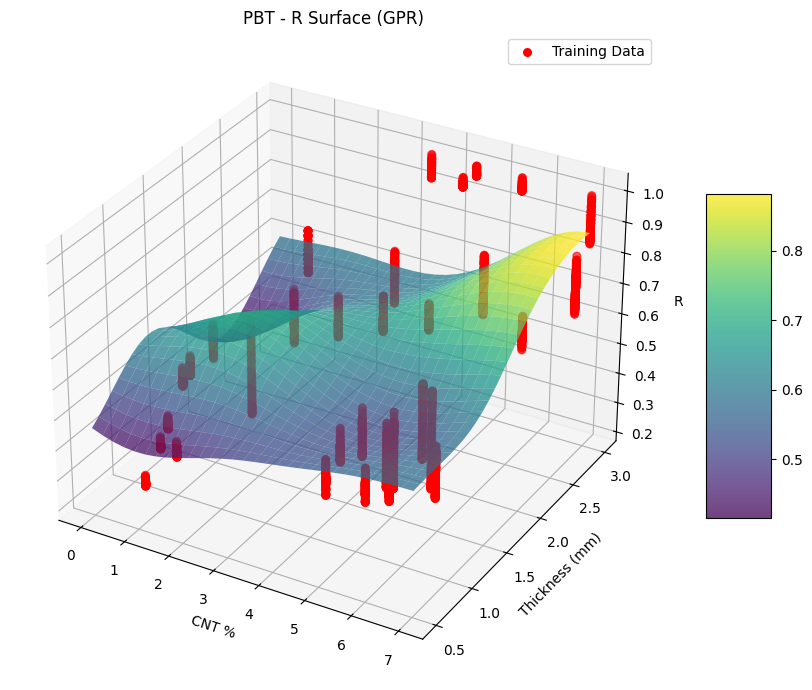

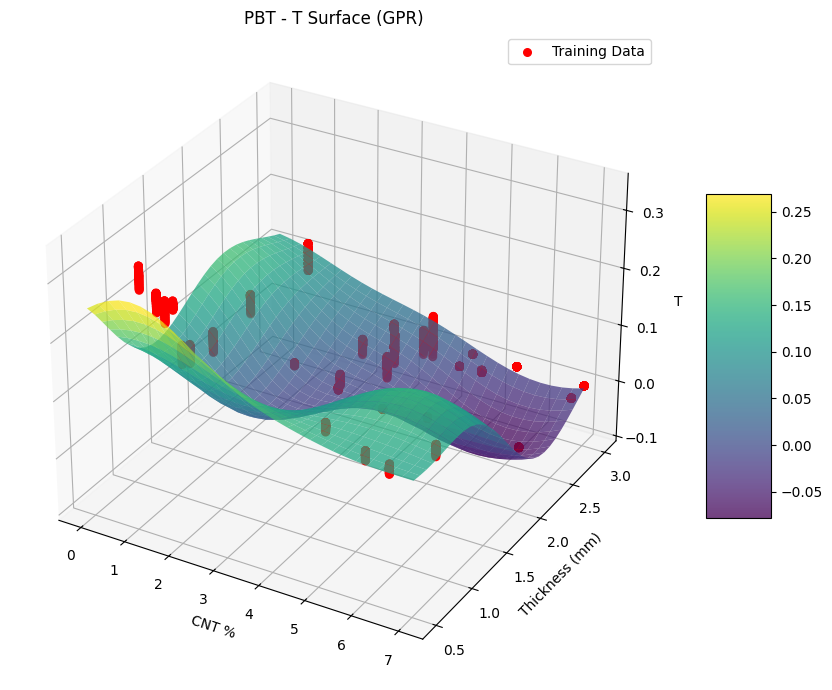

In [30]:
# === For ABS ===
fixed_abs = get_fixed_inputs(abs_combined)
cnt_abs, thick_abs, preds_abs = generate_surface_data(abs_model, scaler_abs, fixed_abs)

for target in ["A", "R", "T"]:
    plot_surface_with_data(cnt_abs, thick_abs, preds_abs, abs_combined, target, "ABS")
# === For PBT ===
fixed_pbt = get_fixed_inputs(pbt_combined)
cnt_pbt, thick_pbt, preds_pbt = generate_surface_data(pbt_model, scaler_pbt, fixed_pbt)

for target in ["A", "R", "T"]:
    plot_surface_with_data(cnt_pbt, thick_pbt, preds_pbt, pbt_combined, target, "PBT")


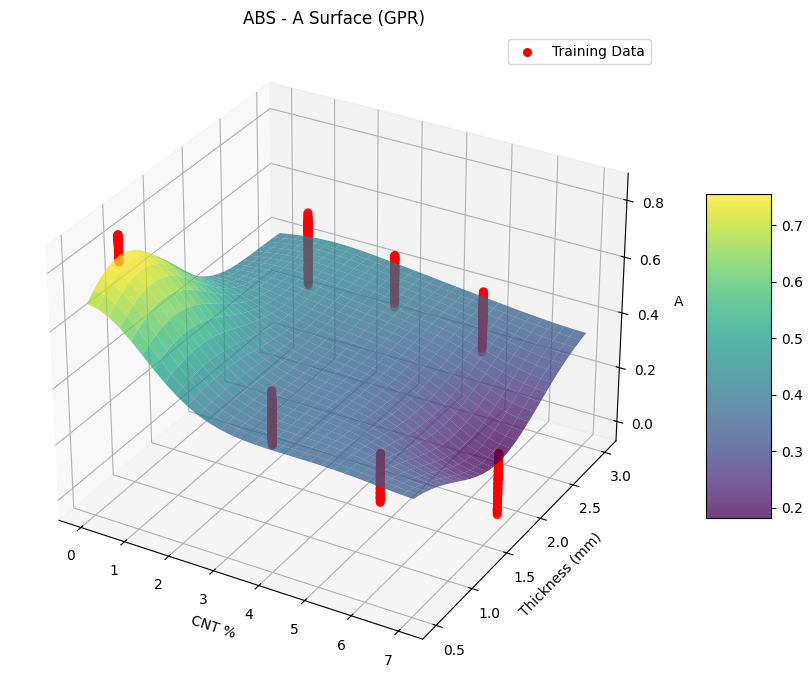

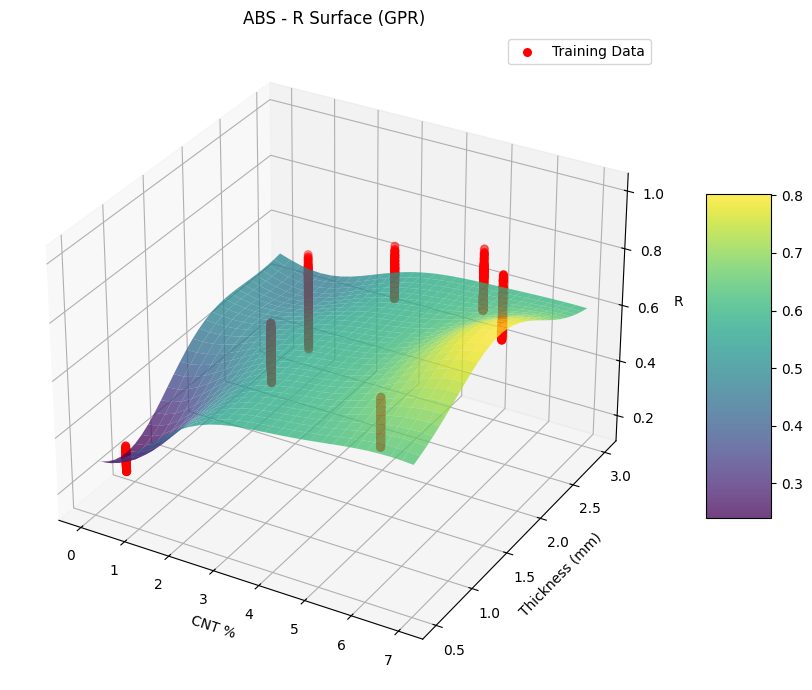

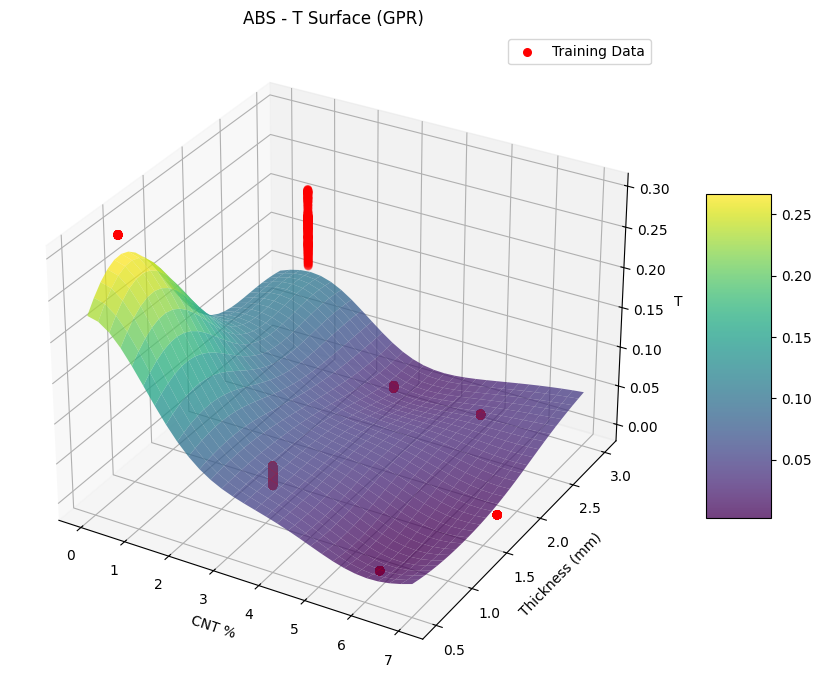

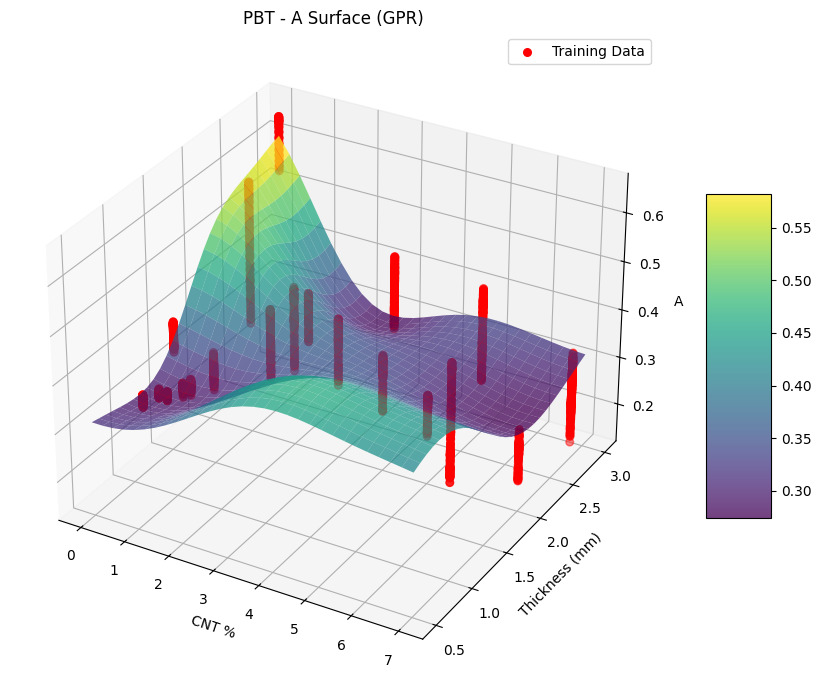

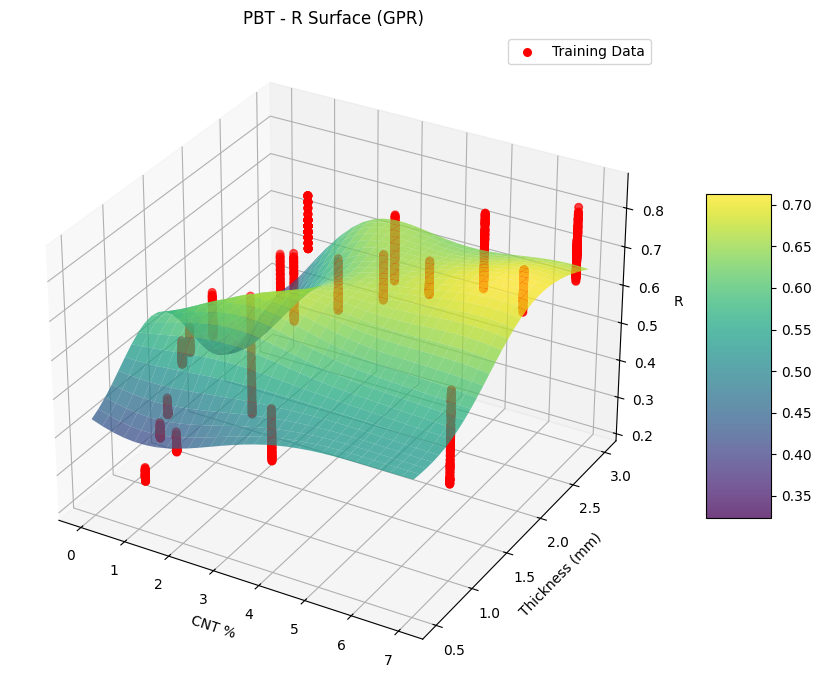

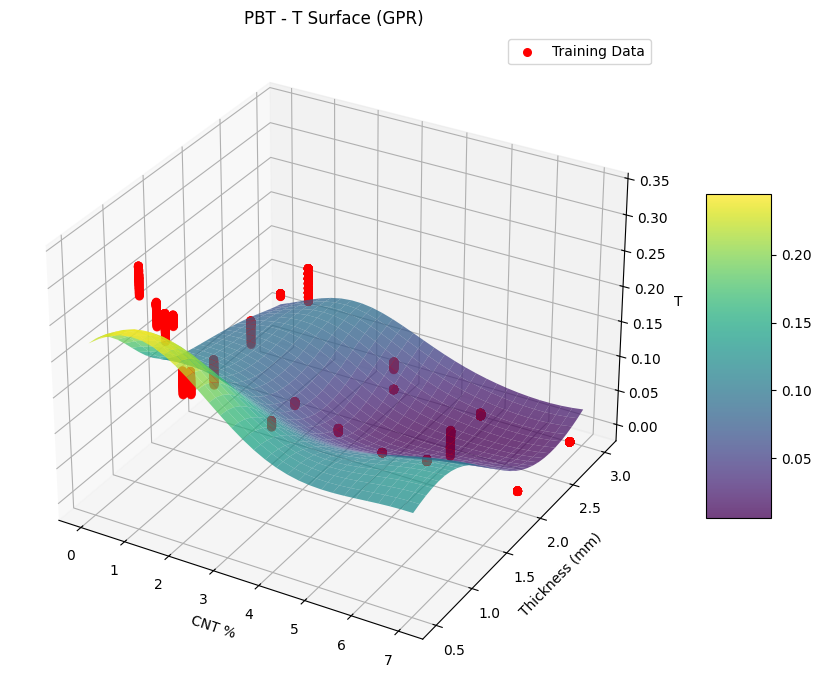

In [15]:
# === For ABS ===
fixed_abs = get_fixed_inputs(abs_combined)
cnt_abs, thick_abs, preds_abs = generate_surface_data(abs_model, scaler_abs, fixed_abs)

for target in ["A", "R", "T"]:
    plot_surface_with_data(cnt_abs, thick_abs, preds_abs, abs_combined, target, "ABS")
# === For PBT ===
fixed_pbt = get_fixed_inputs(pbt_combined)
cnt_pbt, thick_pbt, preds_pbt = generate_surface_data(pbt_model, scaler_pbt, fixed_pbt)

for target in ["A", "R", "T"]:
    plot_surface_with_data(cnt_pbt, thick_pbt, preds_pbt, pbt_combined, target, "PBT")


/usr/local/lib/python3.11/dist-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gpytorch/distributions/multivariate_normal.py:376: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


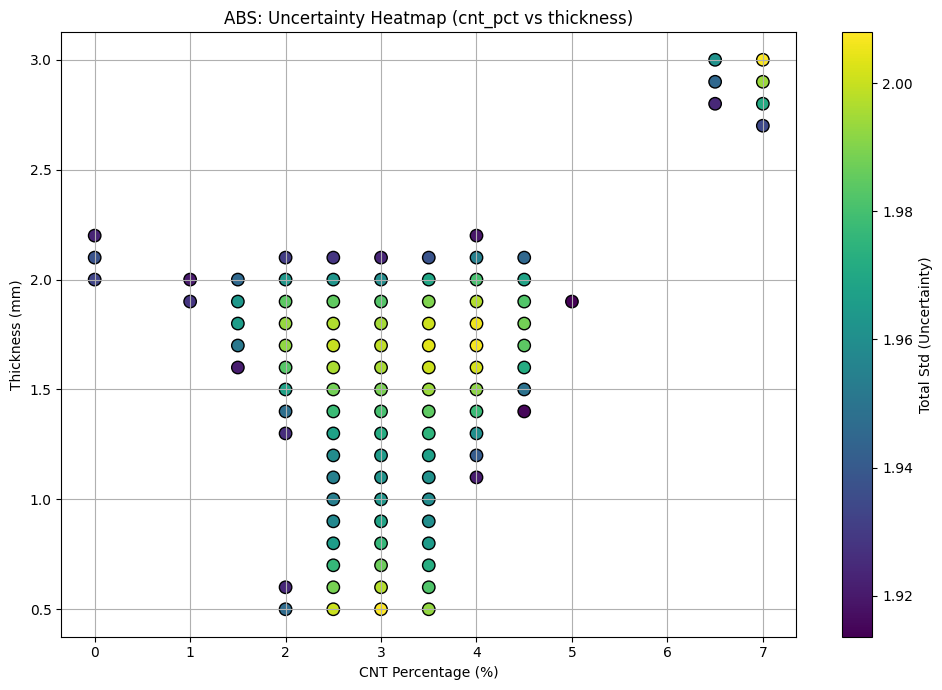

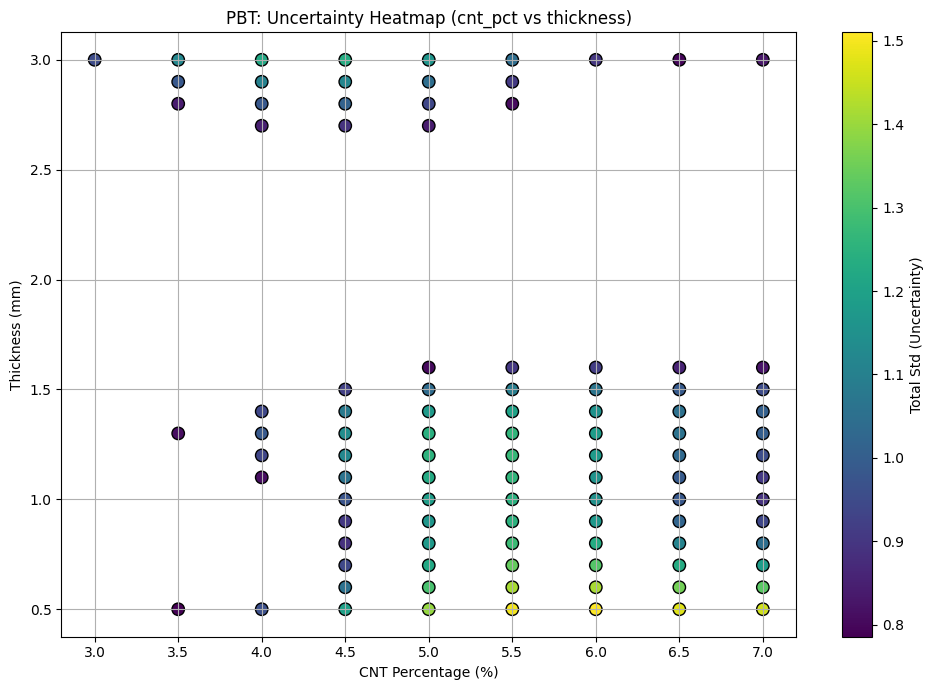

Top 15 Diverse High-Uncertainty Points (ABS):
    cnt_pct  thickness  std_total
0       4.0        1.8   2.005356
1       3.5        1.3   1.975124
2       2.0        1.8   1.993132
3       7.0        3.0   2.007525
4       2.5        1.7   1.999618
5       3.0        0.7   1.986553
6       4.0        1.7   2.006698
7       2.5        1.8   1.996667
8       2.5        0.5   2.000469
9       4.0        1.6   2.001942
10      7.0        2.8   1.971019
11      0.0        2.1   1.937817
12      3.0        1.3   1.971484
13      3.0        0.5   2.007914
14      2.0        1.7   1.992326

Top 15 Diverse High-Uncertainty Points (PBT):
    cnt_pct  thickness  std_total
0       5.5        1.1   1.258837
1       4.5        2.8   1.009545
2       4.5        1.4   1.080261
3       6.0        0.5   1.510175
4       5.0        0.6   1.299689
5       7.0        0.8   1.044888
6       4.5        3.0   1.230511
7       7.0        3.0   0.829940
8       6.5        0.5   1.475857
9       4.5        1.1 

In [16]:
import pandas as pd
import numpy as np
import torch
import gpytorch
from itertools import product
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

# === Step 1: Create grid ===
cnt_vals = np.arange(0.0, 7.1, 0.5)
thickness_vals = np.arange(0.5, 3.1, 0.1)
grid = list(product(cnt_vals, thickness_vals))
grid_df = pd.DataFrame(grid, columns=["cnt_pct", "thickness"])

def prepare_candidate_inputs(grid_df, ref_df):
    grid_df['frequency'] = ref_df['frequency'].mean()
    grid_df['epsilon_real'] = ref_df['epsilon_real'].mean()
    grid_df['sigma'] = ref_df['sigma'].mean()
    return grid_df

# Prepare unseen inputs
abs_candidates_df = prepare_candidate_inputs(grid_df.copy(), abs_combined)
pbt_candidates_df = prepare_candidate_inputs(grid_df.copy(), pbt_combined)

# === Step 2: Predict uncertainties using GPyTorch ===
def evaluate_gpytorch_uncertainty(model, scaler, candidates_df, input_features, k=100):
    X_scaled = scaler.transform(candidates_df[input_features].values.astype(np.float32))
    X_tensor = torch.tensor(X_scaled)

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = model(X_tensor)
        mean = preds.mean.numpy()
        std = preds.variance.sqrt().numpy()

    result_df = candidates_df.copy()
    result_df['std_A'] = std[:, 0]
    result_df['std_R'] = std[:, 1]
    result_df['std_T'] = std[:, 2]
    result_df['std_total'] = result_df[['std_A', 'std_R', 'std_T']].sum(axis=1)

    return result_df.sort_values("std_total", ascending=False).head(k).reset_index(drop=True)

# Apply for ABS and PBT
top_abs_unseen = evaluate_gpytorch_uncertainty(abs_model, scaler_abs, abs_candidates_df, input_features, k=100)
top_pbt_unseen = evaluate_gpytorch_uncertainty(pbt_model, scaler_pbt, pbt_candidates_df, input_features, k=100)

# === Step 3: Plot 2D uncertainty map ===
def plot_uncertainty_2d(df, x_col='cnt_pct', y_col='thickness', c_col='std_total', title="Uncertainty Heatmap"):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(df[x_col], df[y_col], c=df[c_col], cmap='viridis', s=80, edgecolor='black')
    plt.colorbar(sc, label='Total Std (Uncertainty)')
    plt.title(title)
    plt.xlabel('CNT Percentage (%)')
    plt.ylabel('Thickness (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Step 4: Select diverse + uncertain points ===
def select_diverse_uncertain_points(df, k=5, weight_uncertainty=0.8):
    scaler = MinMaxScaler()
    norm_coords = scaler.fit_transform(df[['cnt_pct', 'thickness']])
    weighted = np.hstack([norm_coords, df['std_total'].values.reshape(-1, 1) * weight_uncertainty])

    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(weighted)

    top_diverse = df.loc[df.groupby('cluster')['std_total'].idxmax()].reset_index(drop=True)
    return top_diverse

# === Run for ABS ===
plot_uncertainty_2d(top_abs_unseen, title="ABS: Uncertainty Heatmap (cnt_pct vs thickness)")
diverse_top_abs = select_diverse_uncertain_points(top_abs_unseen, k=15)

# === Run for PBT ===
plot_uncertainty_2d(top_pbt_unseen, title="PBT: Uncertainty Heatmap (cnt_pct vs thickness)")
diverse_top_pbt = select_diverse_uncertain_points(top_pbt_unseen, k=15)

# === Print results ===
print("Top 15 Diverse High-Uncertainty Points (ABS):")
print(diverse_top_abs[['cnt_pct', 'thickness', 'std_total']])

print("\nTop 15 Diverse High-Uncertainty Points (PBT):")
print(diverse_top_pbt[['cnt_pct', 'thickness', 'std_total']])


Vanilla method

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np

# Features and targets
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]

# Helper function to train GPR model
def train_gpr_model(df, name="Material"):
    print(f"🛠️ Training GPR model for {name} ...")

    X = df[input_features].values
    y = df[output_targets].values

    # Define a RationalQuadratic kernel with initial hyperparameters
    kernel = C(1.0, (1e-2, 1e3)) * RationalQuadratic(length_scale=1.0, alpha=0.1)

    # Build a pipeline with scaling and multi-output GPR
    gpr = make_pipeline(
        StandardScaler(),
        MultiOutputRegressor(GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True))
    )

    gpr.fit(X, y)
    print(f"✅ GPR training complete for {name}")
    return gpr

# Train models
abs_gpr = train_gpr_model(abs_df, name="ABS")
pbt_gpr = train_gpr_model(pbt_df, name="PBT")


🛠️ Training GPR model for ABS ...
✅ GPR training complete for ABS
🛠️ Training GPR model for PBT ...
✅ GPR training complete for PBT


In [13]:
import os
import joblib
from datetime import datetime

def save_sklearn_gpr_model(model, material_name, base_path='/content/drive/MyDrive/Thesis_Updated/Models/GPR'):
    """
    Saves the trained scikit-learn GPR model (wrapped in a pipeline) with a timestamped filename.

    Parameters:
    - model: The pipeline containing StandardScaler + MultiOutputRegressor(GPR)
    - material_name: str, e.g., "ABS", "PBT"
    - base_path: target directory in Google Drive
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{material_name}_GPR_Sklearn_{timestamp}.pkl"
    save_path = os.path.join(base_path, filename)

    # Ensure directory exists
    os.makedirs(base_path, exist_ok=True)

    # Save with joblib
    joblib.dump({
        'model': model,
        'material': material_name,
        'timestamp': timestamp
    }, save_path)

    print(f"✅ Sklearn GPR model for {material_name} saved to: {save_path}")

save_sklearn_gpr_model(abs_gpr, "ABS")
save_sklearn_gpr_model(pbt_gpr, "PBT")


✅ Sklearn GPR model for ABS saved to: /content/drive/MyDrive/Thesis_Updated/Models/GPR/ABS_GPR_Sklearn_20250403_172200.pkl
✅ Sklearn GPR model for PBT saved to: /content/drive/MyDrive/Thesis_Updated/Models/GPR/PBT_GPR_Sklearn_20250403_172200.pkl


In [34]:
import pandas as pd
import numpy as np

def select_high_uncertainty_points_df(model, original_df, input_features, output_names, k=5):
    # Unpack the pipeline
    scaler = model.named_steps['standardscaler']
    multi_gpr = model.named_steps['multioutputregressor']

    # Get candidate inputs
    X_candidates = original_df[input_features].values
    X_scaled = scaler.transform(X_candidates)

    # Get std devs per output
    stds = []
    for est in multi_gpr.estimators_:
        _, std = est.predict(X_scaled, return_std=True)
        stds.append(std)

    std_matrix = np.stack(stds, axis=1)  # shape (n_samples, n_outputs)
    std_sum = std_matrix.sum(axis=1)

    # Get top-k indices
    top_k_indices = np.argsort(std_sum)[-k:]

    # Build DataFrame
    top_df = original_df.iloc[top_k_indices][input_features].copy()
    for i, out in enumerate(output_names):
        top_df[f'std_{out}'] = std_matrix[top_k_indices, i]
    top_df["std_total"] = std_sum[top_k_indices]

    return top_df.sort_values("std_total", ascending=False).reset_index(drop=True)
input_features = ["cnt_pct", "thickness", "frequency", "epsilon_real", "sigma"]
output_targets = ["A", "R", "T"]

top_abs_df = select_high_uncertainty_points_df(abs_gpr, abs_df, input_features, output_targets, k=50)
top_pbt_df = select_high_uncertainty_points_df(pbt_gpr, pbt_df, input_features, output_targets, k=50)


In [36]:
def get_top_unique_cnt_thickness(df, k=5):
    # Group by cnt_pct and thickness, then keep the row with the highest std_total per group
    grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
        lambda x: x.sort_values('std_total', ascending=False).head(1)
    ).reset_index(drop=True)

    # Sort all unique combinations by std_total and pick top k
    top_unique = grouped.sort_values('std_total', ascending=False).head(k).reset_index(drop=True)
    return top_unique[['cnt_pct', 'thickness', 'std_A', 'std_R', 'std_T', 'std_total']]
top_abs_combos = get_top_unique_cnt_thickness(top_abs_df, k=5)
top_pbt_combos = get_top_unique_cnt_thickness(top_pbt_df, k=5)


<ipython-input-36-68ad6423c443>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
<ipython-input-36-68ad6423c443>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby(['cnt_pct', 'thickness'], as_index=False).apply(


In [37]:
top_abs_combos

cnt_pct  thickness         std_A     std_R         std_T  std_total
0        3        2.8  8.073845e-07  0.000001  6.741358e-07   0.000003
1        3        1.1  8.073630e-07  0.000001  6.741597e-07   0.000003
2        1        2.8  8.073200e-07  0.000001  6.741478e-07   0.000003
3        5        2.8  8.073200e-07  0.000001  6.741358e-07   0.000003

In [43]:
# Grid ranges
cnt_vals = np.arange(0.0, 7.1, 0.5)        # 0.0 to 7.0 inclusive
thickness_vals = np.arange(0.5, 3.1, 0.1)  # 0.5 to 3.0 inclusive

# Create full grid of combinations
grid = list(product(cnt_vals, thickness_vals))
grid_df = pd.DataFrame(grid, columns=["cnt_pct", "thickness"])

def prepare_candidate_inputs(grid_df, ref_df):
    default_freq = 15e9
    default_eps = ref_df['epsilon_real'].mean()
    default_sigma = ref_df['sigma'].mean()

    grid_df['frequency'] = default_freq
    grid_df['epsilon_real'] = default_eps
    grid_df['sigma'] = default_sigma
    return grid_df[input_features]
abs_candidates_df = prepare_candidate_inputs(grid_df.copy(), abs_df)
pbt_candidates_df = prepare_candidate_inputs(grid_df.copy(), pbt_df)


def evaluate_uncertainty_over_candidates(model, input_df, input_features, output_names, full_metadata_df, k=5):
    scaler = model.named_steps['standardscaler']
    multi_gpr = model.named_steps['multioutputregressor']

    X_scaled = scaler.transform(input_df[input_features].values)

    stds = []
    for est in multi_gpr.estimators_:
        _, std = est.predict(X_scaled, return_std=True)
        stds.append(std)

    std_matrix = np.stack(stds, axis=1)
    std_sum = std_matrix.sum(axis=1)

    # Build DataFrame
    df_out = full_metadata_df.copy()
    for i, out in enumerate(output_names):
        df_out[f'std_{out}'] = std_matrix[:, i]
    df_out["std_total"] = std_sum

    # Group by cnt_pct and thickness to find unique uncertainty combos
    grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
        lambda x: x.sort_values('std_total', ascending=False).head(1)
    ).reset_index(drop=True)

    top_unique = grouped.sort_values('std_total', ascending=False).head(k).reset_index(drop=True)
    return top_unique[['cnt_pct', 'thickness', 'std_A', 'std_R', 'std_T', 'std_total']]

top_abs_unseen = evaluate_uncertainty_over_candidates(
    abs_gpr, abs_candidates_df, input_features, output_targets, grid_df, k=100
)

top_pbt_unseen = evaluate_uncertainty_over_candidates(
    pbt_gpr, pbt_candidates_df, input_features, output_targets, grid_df, k=100
)

top_abs_unseen

<ipython-input-43-b7ca00105d32>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(
<ipython-input-43-b7ca00105d32>:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_out.groupby(['cnt_pct', 'thickness'], as_index=False).apply(


cnt_pct  thickness     std_A     std_R     std_T  std_total
0       7.0        0.5  0.030937  0.038190  0.021222   0.090349
1       7.0        0.6  0.030888  0.038123  0.021164   0.090175
2       7.0        0.7  0.030840  0.038056  0.021106   0.090002
3       7.0        0.8  0.030793  0.037990  0.021049   0.089832
4       7.0        0.9  0.030746  0.037925  0.020992   0.089663
..      ...        ...       ...       ...       ...        ...
95      6.5        2.5  0.029717  0.036484  0.019702   0.085904
96      5.0        0.8  0.029710  0.036473  0.019715   0.085897
97      6.5        2.8  0.029712  0.036478  0.019692   0.085882
98      1.0        0.8  0.029704  0.036464  0.019709   0.085877
99      6.5        2.6  0.029704  0.036466  0.019684   0.085854

[100 rows x 6 columns]

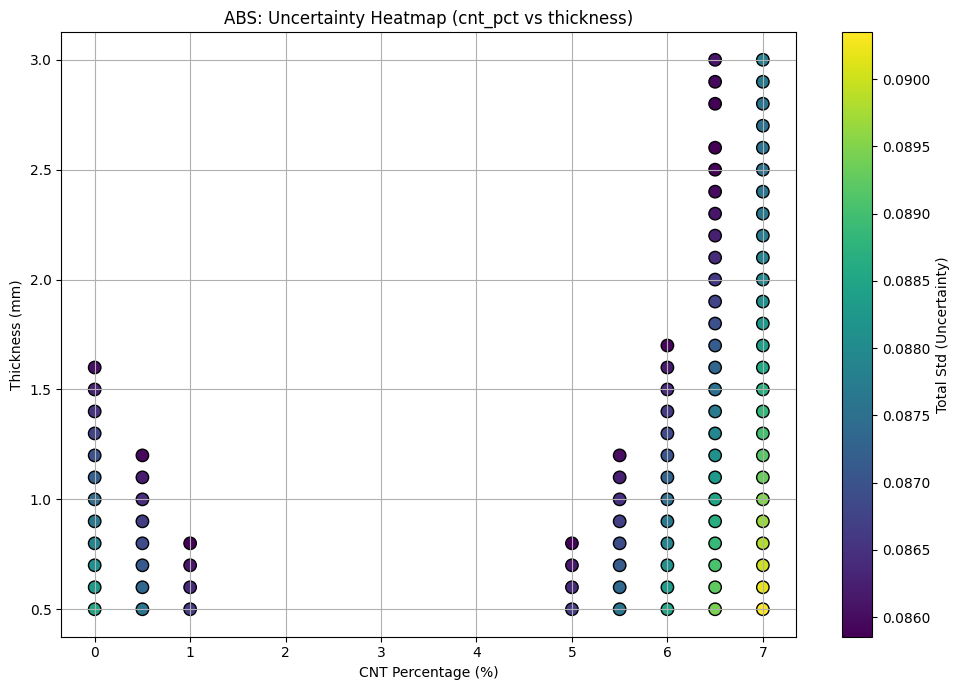

Top 5 Diverse High-Uncertainty Points (ABS):
    cnt_pct  thickness  std_total
0       6.0        0.7   0.088096
1       0.0        0.9   0.087640
2       7.0        1.7   0.088380
3       7.0        3.0   0.087755
4       7.0        1.2   0.089166
5       5.5        0.5   0.087589
6       7.0        0.5   0.090349
7       6.5        1.5   0.087527
8       0.5        0.5   0.087577
9       0.0        1.0   0.087424
10      7.0        0.8   0.089832
11      7.0        2.2   0.087746
12      0.0        0.5   0.088507
13      0.0        1.3   0.086758
14      6.0        1.1   0.087259


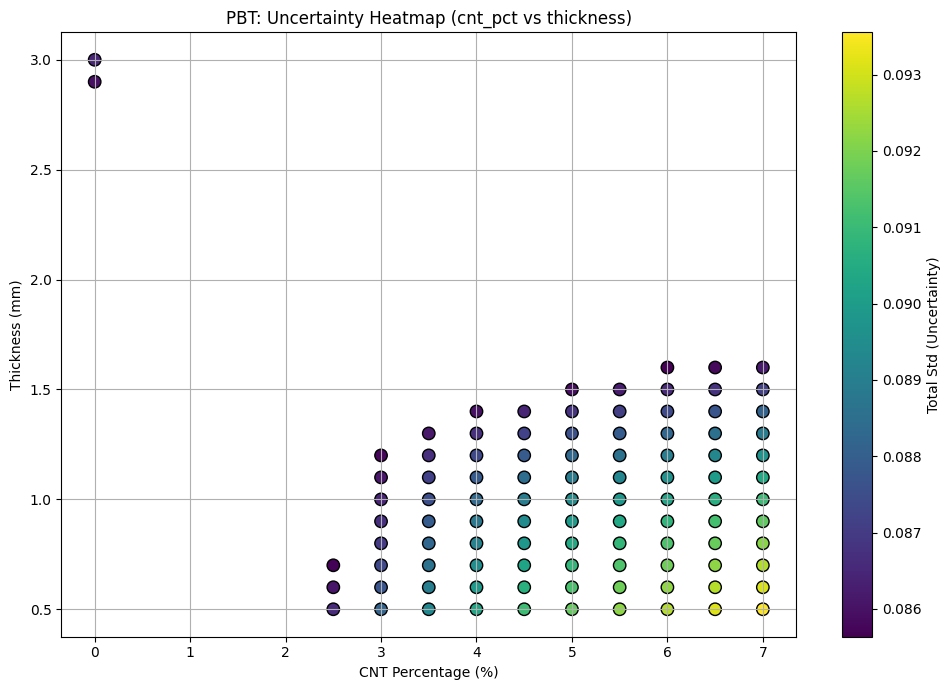

Top 5 Diverse High-Uncertainty Points (ABS):
    cnt_pct  thickness  std_total
0       7.0        1.0   0.091025
1       3.5        0.8   0.088244
2       0.0        3.0   0.086439
3       5.5        1.2   0.088627
4       6.5        0.5   0.093124
5       4.5        0.9   0.089429
6       4.5        0.5   0.091054
7       3.5        0.5   0.089338
8       7.0        0.5   0.093554
9       4.0        1.2   0.087363
10      6.0        1.0   0.090237
11      7.0        1.4   0.088081
12      5.5        0.8   0.090893
13      5.0        1.2   0.088275
14      5.5        0.5   0.092211


In [45]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def plot_uncertainty_2d(df, x_col='cnt_pct', y_col='thickness', c_col='std_total', title="Uncertainty Heatmap"):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(df[x_col], df[y_col], c=df[c_col],
                     cmap='viridis', s=80, edgecolor='black')
    plt.colorbar(sc, label='Total Std (Uncertainty)')
    plt.title(title)
    plt.xlabel('CNT Percentage (%)')
    plt.ylabel('Thickness (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def select_diverse_uncertain_points(df, k=5, weight_uncertainty=0.8):
    # Normalize cnt_pct and thickness
    scaler = MinMaxScaler()
    normalized_coords = scaler.fit_transform(df[['cnt_pct', 'thickness']])

    # Add weighted uncertainty as a 3rd dimension
    weighted_features = np.hstack([
        normalized_coords,
        df['std_total'].values.reshape(-1, 1) * weight_uncertainty  # Adjust weight if needed
    ])

    # KMeans clustering for diversity
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(weighted_features)

    # Pick the most uncertain point in each cluster
    top_diverse = df.loc[df.groupby('cluster')['std_total'].idxmax()].reset_index(drop=True)
    return top_diverse

# Step 1: Plot
plot_uncertainty_2d(top_abs_unseen, title="ABS: Uncertainty Heatmap (cnt_pct vs thickness)")

# Step 2: Get diverse + high-uncertainty samples
diverse_top5_abs = select_diverse_uncertain_points(top_abs_unseen, k=15)

# View the result
print("Top 5 Diverse High-Uncertainty Points (ABS):")
print(diverse_top5_abs[['cnt_pct', 'thickness', 'std_total']])


# Step 1: Plot
plot_uncertainty_2d(top_pbt_unseen, title="PBT: Uncertainty Heatmap (cnt_pct vs thickness)")

# Step 2: Get diverse + high-uncertainty samples
diverse_top5_pbt = select_diverse_uncertain_points(top_pbt_unseen, k=15)

# View the result
print("Top 5 Diverse High-Uncertainty Points (ABS):")
print(diverse_top5_pbt[['cnt_pct', 'thickness', 'std_total']])

In [11]:
import os
import joblib
import torch
from datetime import datetime

def save_multioutput_gpr_models(models, scaler, material_name, base_path='/content/drive/MyDrive/Thesis_Updated/Models/GPR'):
    """
    Saves a list of trained GPR models (one per output: A, R, T) along with the StandardScaler
    to a timestamped file in the specified folder.

    Parameters:
    - models: list of (model, likelihood) tuples
    - scaler: StandardScaler object used for inputs
    - material_name: string, name of material (e.g., "ABS", "PBT")
    - base_path: directory to save the model
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{material_name}_GPR_Models_{timestamp}.pt"
    save_path = os.path.join(base_path, filename)

    # Ensure the directory exists
    os.makedirs(base_path, exist_ok=True)

    # Collect model and likelihood state dicts
    model_data = {
        'models': [model.state_dict() for model, _ in models],
        'likelihoods': [likelihood.state_dict() for _, likelihood in models],
        'scaler': scaler,
        'material': material_name,
        'timestamp': timestamp
    }

    # Save everything using torch
    torch.save(model_data, save_path)
    print(f"✅ Saved GPR models for {material_name} at: {save_path}")


In [12]:
save_multioutput_gpr_models(abs_gpr, "ABS")
save_multioutput_gpr_models(pbt_gpr, "PBT")

NameError: name 'abs_models' is not defined